In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from typing import Tuple, List, Dict, Optional, Any, Callable, Union
import warnings
from collections import defaultdict
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.init as init



In [2]:

with open("all_dataframes.pkl", "rb") as f:
    loaded_dfs = pickle.load(f)

# Access them like before:
data_df = loaded_dfs['data_df']
id_df = loaded_dfs['id_df']
train_df = loaded_dfs['train_df']
val_df = loaded_dfs['val_df']
test_df = loaded_dfs['test_df']
train_id_df = loaded_dfs['train_id_df']
val_id_df = loaded_dfs['val_id_df']
test_id_df = loaded_dfs['test_id_df']
data_df_high_energy = loaded_dfs['data_df_high_energy']
id_df_high_energy = loaded_dfs['id_df_high_energy']
val_df_high_energy = loaded_dfs['val_df_high_energy']
test_df_high_energy = loaded_dfs['test_df_high_energy']
val_id_df_high_energy = loaded_dfs['val_id_df_high_energy']
test_id_df_high_energy = loaded_dfs['test_id_df_high_energy']

In [3]:
def get_data_from_trajectory_id(ids_df, data_df, trajectory_ids):
    """
    Return the exact portion(s) of `data_df` corresponding to one or more trajectory_ids.
    - Preserves data_df's original indexing (no reset).
    - If trajectory_ids contains all ids in ids_df, returns data_df unchanged.
    - If any requested id is missing, prints missing ids and returns None.
    """
    # normalize to list of ints (preserve order)
    if isinstance(trajectory_ids, (np.integer, int)):
        trajectory_ids = [int(trajectory_ids)]
    else:
        trajectory_ids = [int(x) for x in trajectory_ids]

    # ensure id columns are ints in ids_df
    ids_df = ids_df.copy()
    for col in ("start_index", "end_index", "generated_points", "trajectory_id"):
        if col in ids_df.columns:
            ids_df[col] = ids_df[col].astype("int64")

    existing_ids = list(ids_df["trajectory_id"].values)
    missing = [tid for tid in trajectory_ids if tid not in existing_ids]
    if missing:
        print(f"trajectory_id(s) {missing} not in ids_df. Pick from {existing_ids}")
        return None

    # special-case: request for all trajectories -> return full data_df unchanged
    if set(trajectory_ids) == set(existing_ids):
        return data_df

    parts = []
    for tid in trajectory_ids:
        row = ids_df.loc[ids_df["trajectory_id"] == tid].iloc[0]
        start = int(row["start_index"])
        end = int(row["end_index"])   # exclusive by your convention

        if start >= end:
            # empty trajectory: skip (or you can append an empty frame if you prefer)
            continue

        # label-based selection: .loc is inclusive on the right, so use end-1
        sub = data_df.loc[start : end - 1]
        parts.append(sub)

    if not parts:
        # nothing found (all requested trajectories empty)
        return data_df.iloc[0:0]   # empty DataFrame with same columns

    # if single part, return it directly (preserves original index)
    if len(parts) == 1:
        return parts[0]
    # multiple parts: concatenate preserving indices and order
    return pd.concat(parts)

def get_trajectory_ids_by_energies(ids_df, want_more_energy, energy_percentile):
    if want_more_energy==False:
        return list(ids_df[ids_df['energy'] < ids_df['energy'].quantile(energy_percentile)]['trajectory_id'])
    if want_more_energy==True:
        return list(ids_df[ids_df['energy'] > ids_df['energy'].quantile(energy_percentile)]['trajectory_id'])
    

In [4]:
def find_valid_combinations(train_df, train_id_df, max_segment_length=20, max_n_segments=50):
    results = []
    
    total_points = len(train_df)
    n_trajectories = len(train_id_df['trajectory_id'].unique())
    
    # Get actual trajectory lengths (might vary)
    traj_lengths = []
    for _, row in train_id_df.iterrows():
        length = int(row['end_index'] - row['start_index'])
        traj_lengths.append(length)
    
    # If all trajectories same length, use that; otherwise use minimum
    if len(set(traj_lengths)) == 1:
        points_per_traj = traj_lengths[0]
    else:
        points_per_traj = min(traj_lengths)
        print(f"Warning: Trajectories have different lengths. Using minimum: {points_per_traj}")
    
    # Find divisors of points_per_traj for valid segment lengths
    valid_segment_lengths = []
    for s in range(1, min(max_segment_length + 1, points_per_traj + 1)):
        if points_per_traj % s == 0:
            valid_segment_lengths.append(s)
    
    for segment_length in valid_segment_lengths:
        max_segments_per_traj = points_per_traj // segment_length
        
        for n_segments in range(1, min(max_n_segments + 1, max_segments_per_traj + 1)):
            # Check if trajectories can be evenly distributed across batches
            if max_segments_per_traj % n_segments != 0:
                continue
            
            batches_per_traj = max_segments_per_traj // n_segments
            
            # Try different batch compositions
            for batch_traj in range(1, n_trajectories + 1):
                # Total batches must use all trajectories evenly
                if (n_trajectories * batches_per_traj) % batch_traj != 0:
                    continue
                
                total_batches = (n_trajectories * batches_per_traj) // batch_traj
                
                # Verify coverage
                total_points_covered = total_batches * batch_traj * n_segments * segment_length
                
                # For exact coverage (adjust if allowing partial coverage)
                if total_points_covered != n_trajectories * points_per_traj:
                    continue
                
                batch_ppt = n_segments * segment_length
                batch_size = batch_traj * batch_ppt
                ratio = batch_ppt / batch_traj
                

                
                results.append({
                    "segment_length": segment_length,
                    "n_segments": n_segments,
                    "batch_traj": batch_traj,
                    "batch_ppt": batch_ppt,
                    "batch_size": batch_size,
                    "total_batches": total_batches,
                    "ratio": ratio,
                    "coverage_pct": (total_points_covered / total_points) * 100,
                    "points_per_traj": points_per_traj
                })
    
    df = pd.DataFrame(results)
    
    if len(df) == 0:
        print("No valid combinations found with given constraints!")
        print(f"Dataset: {total_points} points, {n_trajectories} trajectories, {points_per_traj} points/traj")
        print(f"Valid segment lengths: {valid_segment_lengths[:10]}...")
    
    return df

df_valid_combinations_new = find_valid_combinations(train_df, train_id_df, max_segment_length=20, max_n_segments=50)
df_valid_combinations_new[(df_valid_combinations_new['ratio'] >= 1.8) & (df_valid_combinations_new['ratio'] <= 2.6)]


,segment_length,n_segments,batch_traj,batch_ppt,batch_size,total_batches,ratio,coverage_pct,points_per_traj
19,1,2,1,2,2,11616,2.000000,100.0,242
41,1,11,6,11,66,352,1.833333,100.0,242
62,1,22,11,22,242,96,2.000000,100.0,242
63,1,22,12,22,264,88,1.833333,100.0,242
74,2,1,1,2,2,11616,2.000000,100.0,242
98,2,11,11,22,242,96,2.000000,100.0,242
99,2,11,12,22,264,88,1.833333,100.0,242
114,11,1,6,11,66,352,1.833333,100.0,242
135,11,2,11,22,242,96,2.000000,100.0,242
136,11,2,12,22,264,88,1.833333,100.0,242


In [5]:
class SimpleHarmonicDataLoader:
    def __init__(self, train_df, train_id_df, ratio, batch_size, segment_length, get_data_func, seed=42):
        """
        Simple dataloader with guaranteed full coverage.
        
        Args:
            ratio: points_per_trajectory / trajectories_per_batch
            batch_size: total points per batch
            segment_length: consecutive points per segment
        """
        self.train_df = train_df
        self.train_id_df = train_id_df
        self.get_data_func = get_data_func
        self.ratio = ratio
        self.batch_size = batch_size
        self.segment_length = segment_length
        
        np.random.seed(seed)
        
        # Calculate derived parameters
        self.n_trajectories = len(train_id_df['trajectory_id'].unique())
        self.total_points = len(train_df)
        self.points_per_traj = self.total_points // self.n_trajectories
        
        # Validate hyperparameters
        valid_df = find_valid_combinations(train_df, train_id_df, max_segment_length=25, max_n_segments=50)
        valid_params = valid_df[
            (np.isclose(valid_df['ratio'], ratio, rtol=0.01)) & 
            (valid_df['batch_size'] == batch_size) & 
            (valid_df['segment_length'] == segment_length)
        ]
        
        if len(valid_params) == 0:
            raise ValueError(f"Invalid hyperparameters: ratio={ratio}, batch_size={batch_size}, segment_length={segment_length}")
        
        # Extract validated parameters
        row = valid_params.iloc[0]
        self.batch_traj = int(row['batch_traj'])
        self.n_segments = int(row['n_segments'])
        self.total_batches = int(row['total_batches'])
        
        # Compatibility aliases for validation function
        self.actual_batch_size = self.batch_size
        self.number_of_trajectories = self.batch_traj
        self.points_per_trajectory = self.n_segments * self.segment_length
        self.segments_per_trajectory = self.n_segments
        
        print(f"Dataloader initialized:")
        print(f"  Trajectories per batch: {self.batch_traj}")
        print(f"  Segments per trajectory: {self.n_segments}")
        print(f"  Points per trajectory: {self.points_per_trajectory}")
        print(f"  Total batches: {self.total_batches}")
        
        self.trajectory_segments = {}
        for _, row in train_id_df.iterrows():
            tid = int(row['trajectory_id'])
            start_idx = int(row['start_index'])
            
            # All possible segment starting positions for this trajectory
            segments = []
            for i in range(0, self.points_per_traj, self.segment_length):
                segments.append(start_idx + i)
            self.trajectory_segments[tid] = segments
        
        # Generate epoch plan
        self._generate_epoch_plan()
 
    
    def _generate_epoch_plan(self):
        """Generate batches with more balanced trajectory usage."""
        self.batches = []
        
        # Track remaining segments for each trajectory
        remaining_segments = {}
        for tid, segments in self.trajectory_segments.items():
            remaining_segments[tid] = segments.copy()
        
        while True:
            # Find trajectories with at least n_segments remaining
            available = [(tid, len(segs)) for tid, segs in remaining_segments.items() 
                        if len(segs) >= self.n_segments]
            
            if len(available) < self.batch_traj:
                # Final batch with all remaining trajectories that have segments
                if available:
                    batch_data = {}
                    for tid, _ in available:
                        segments = remaining_segments[tid]
                        np.random.shuffle(segments)
                        selected = segments[:min(self.n_segments, len(segments))]
                        batch_data[tid] = selected
                        # Remove used segments
                        for seg in selected:
                            remaining_segments[tid].remove(seg)
                    self.batches.append(batch_data)
                break
            
            # Sort by number of remaining segments (descending) to prioritize fuller trajectories
            available.sort(key=lambda x: x[1], reverse=True)
            
            # Add some randomness but favor trajectories with more segments
            # Take top 2*batch_traj candidates and randomly select from them
            candidates = [tid for tid, _ in available[:min(2 * self.batch_traj, len(available))]]
            np.random.shuffle(candidates)
            selected_tids = candidates[:self.batch_traj]
            
            # Build batch
            batch_data = {}
            for tid in selected_tids:
                segments = remaining_segments[tid]
                np.random.shuffle(segments)
                selected = segments[:self.n_segments]
                batch_data[tid] = selected
                # Remove used segments
                for seg in selected:
                    remaining_segments[tid].remove(seg)
            
            self.batches.append(batch_data)
        
        print(f"Generated {len(self.batches)} batches")
        if self.batches and len(self.batches[-1]) < self.batch_traj:
            print(f"Last batch has {len(self.batches[-1])} trajectories (partial batch)")
    def __len__(self):
        return len(self.batches)
    
    def __getitem__(self, idx):
        """Get batch data."""
        batch_data = self.batches[idx]
        
        x_list, u_list, t_list, tid_list, energy_list = [], [], [], [], []
        
        for tid, segment_starts in batch_data.items():
            # Get trajectory data once
            traj_data = self.get_data_func(self.train_id_df, self.train_df, tid)
            traj_info = self.train_id_df[self.train_id_df['trajectory_id'] == tid].iloc[0]
            traj_start = int(traj_info['start_index'])
            energy = traj_info['energy']
            
            # Process each segment
            for seg_start in segment_starts:
                for offset in range(self.segment_length):
                    relative_idx = seg_start - traj_start + offset
                    x_list.append(traj_data.iloc[relative_idx]['x'])
                    u_list.append(traj_data.iloc[relative_idx]['u'])
                    t_list.append(traj_data.iloc[relative_idx]['t'])
                    tid_list.append(tid)
                    energy_list.append(energy)
        
        return {
            'x': torch.tensor(x_list, dtype=torch.float32),
            'u': torch.tensor(u_list, dtype=torch.float32),
            't': torch.tensor(t_list, dtype=torch.float32),
            'trajectory_ids': torch.tensor(tid_list, dtype=torch.long),
            'energies': torch.tensor(energy_list, dtype=torch.float32)
        }


def create_simple_dataloader(train_df, train_id_df, ratio, batch_size, segment_length, get_data_func, seed=42):
    """Create dataloader with validation."""
    dataset = SimpleHarmonicDataLoader(
        train_df, train_id_df, ratio, batch_size, segment_length, get_data_func, seed
    )
    
    dataloader = DataLoader(
        dataset,
        batch_size=1,  # Dataset handles batching
        shuffle=False,  # Already shuffled in epoch plan
        collate_fn=lambda x: x[0]
    )
    
    return dataloader

In [6]:
df_valid_combinations_new[(df_valid_combinations_new['ratio'] >= 1.5) & (df_valid_combinations_new['ratio'] <= 2.6)]

,segment_length,n_segments,batch_traj,batch_ppt,batch_size,total_batches,ratio,coverage_pct,points_per_traj
19,1,2,1,2,2,11616,2.000000,100.0,242
41,1,11,6,11,66,352,1.833333,100.0,242
62,1,22,11,22,242,96,2.000000,100.0,242
63,1,22,12,22,264,88,1.833333,100.0,242
74,2,1,1,2,2,11616,2.000000,100.0,242
98,2,11,11,22,242,96,2.000000,100.0,242
99,2,11,12,22,264,88,1.833333,100.0,242
114,11,1,6,11,66,352,1.833333,100.0,242
135,11,2,11,22,242,96,2.000000,100.0,242
136,11,2,12,22,264,88,1.833333,100.0,242


In [7]:
# Find valid combinations
valid_df = find_valid_combinations(train_df, train_id_df)
print(valid_df[valid_df['ratio'].between(1.5, 2.6)])

# Pick one valid combination
dataloader = create_simple_dataloader(
    train_df=train_df,
    train_id_df=train_id_df,
    ratio=2.000,
    batch_size=242,
    segment_length=11,
    get_data_func=get_data_from_trajectory_id,
    seed=42
)

     segment_length  n_segments  batch_traj  batch_ppt  batch_size  \
19                1           2           1          2           2   
41                1          11           6         11          66   
62                1          22          11         22         242   
63                1          22          12         22         264   
74                2           1           1          2           2   
98                2          11          11         22         242   
99                2          11          12         22         264   
114              11           1           6         11          66   
135              11           2          11         22         242   
136              11           2          12         22         264   
157              11          11          48        121        5808   
158              11          11          64        121        7744   
171              11          22          96        242       23232   

     total_batches 

In [8]:
def diff_with_previous(nums):
    if not nums:
        return []
    return [nums[0]] + [nums[i] - nums[i-1] for i in range(1, len(nums))]

In [9]:
from collections import Counter

def analyze_gaps(nums):
    # 1) Find smallest number > 1
    greater_than_one = [n for n in nums if n > 1]
    if not greater_than_one:
        return None, False, False  # no valid numbers
    smallest = min(greater_than_one)
    
    # 2) Check divisibility
    divisible = all(n % smallest == 0 for n in greater_than_one)
    
    # 3) Check if it's the most common number
    freq = Counter(nums)
    most_common_num, most_common_count = freq.most_common(1)[0]
    is_most_common = (smallest == most_common_num)
    
    return smallest, divisible, is_most_common




DATALOADER VALIDATION

Expected Parameters:
  - Batch size: 242
  - Trajectories per batch (K): 11
  - Points per trajectory (T): 22
  - Segments per trajectory (S): 2
  - Segment length (w): 11
  - Total batches: 96
  - Total trajectories in dataset: 96


Validating Batch 1/96...

Validating Batch 2/96...

Validating Batch 3/96...

Validating Batch 4/96...

Validating Batch 5/96...

Validating Batch 6/96...

Validating Batch 7/96...

Validating Batch 8/96...

Validating Batch 9/96...

Validating Batch 10/96...

Validating Batch 11/96...

Validating Batch 12/96...

Validating Batch 13/96...

Validating Batch 14/96...

Validating Batch 15/96...

Validating Batch 16/96...

Validating Batch 17/96...

Validating Batch 18/96...

Validating Batch 19/96...

Validating Batch 20/96...

Validating Batch 21/96...

Validating Batch 22/96...

Validating Batch 23/96...

Validating Batch 24/96...

Validating Batch 25/96...

Validating Batch 26/96...

Validating Batch 27/96...

Validating Batch 28/96.

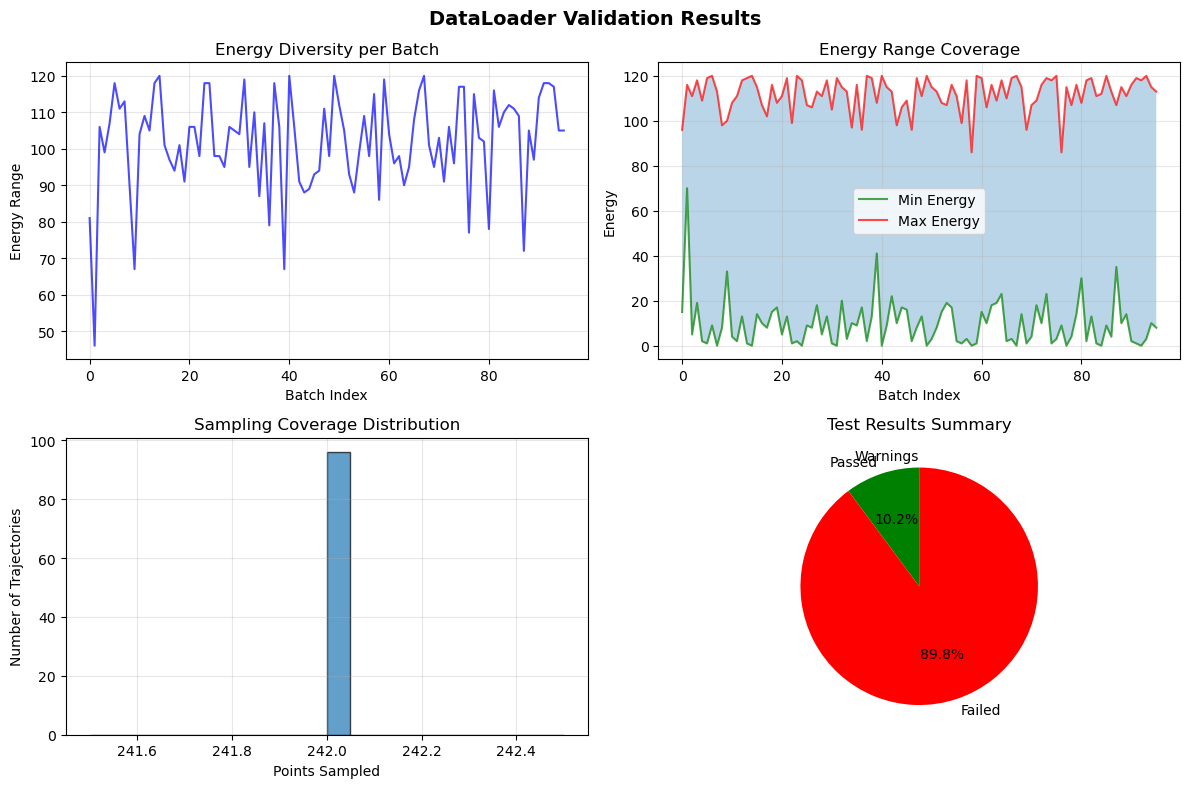

In [10]:

def validate_dataloader_fixed(
    dataloader,
    train_df: pd.DataFrame,
    train_id_df: pd.DataFrame,
    get_data_func,
    verbose: bool = True,
    plot_results: bool = True
) -> Dict[str, Any]:
    """
    Comprehensive validation of the harmonic oscillator dataloader with floating-point tolerance.
    
    Args:
        dataloader: The DataLoader to validate
        train_df: Original training DataFrame
        train_id_df: Trajectory metadata DataFrame
        get_data_func: Function to extract trajectory data
        verbose: Whether to print detailed information
        plot_results: Whether to plot validation results
    
    Returns:
        Dictionary with validation results and statistics
    """
    
    results = {
        'passed_tests': [],
        'failed_tests': [],
        'warnings': [],
        'statistics': {},
        'detailed_info': {}
    }
    
    # Get dataset parameters
    dataset = dataloader.dataset
    expected_batch_size = dataset.actual_batch_size
    expected_trajectories_per_batch = dataset.number_of_trajectories
    expected_points_per_trajectory = dataset.points_per_trajectory
    segment_length = dataset.segment_length
    segments_per_trajectory = dataset.segments_per_trajectory
    
    if verbose:
        print("="*80)
        print("DATALOADER VALIDATION")
        print("="*80)
        print(f"\nExpected Parameters:")
        print(f"  - Batch size: {expected_batch_size}")
        print(f"  - Trajectories per batch (K): {expected_trajectories_per_batch}")
        print(f"  - Points per trajectory (T): {expected_points_per_trajectory}")
        print(f"  - Segments per trajectory (S): {segments_per_trajectory}")
        print(f"  - Segment length (w): {segment_length}")
        print(f"  - Total batches: {len(dataloader)}")
        print(f"  - Total trajectories in dataset: {len(train_id_df)}")
        print("\n" + "="*80)
    
    # Track all sampled points across the epoch
    epoch_points_tracker = defaultdict(set)  # {trajectory_id: set of (relative_index)}
    batch_statistics = []
    
    # Helper function to find index with floating-point tolerance
    def find_time_index(traj_data, t_value, rtol=1e-3, atol=1e-3):
        """Find index of time value with floating-point tolerance."""
        matches = traj_data[np.isclose(traj_data['t'], t_value, rtol=rtol, atol=atol)]
        if len(matches) == 0:
            return None
        return matches.index[0]
    
    # Iterate through all batches
    for batch_idx, batch in enumerate(dataloader):
        if verbose:
            print(f"\nValidating Batch {batch_idx + 1}/{len(dataloader)}...")

        
        # TEST 1: Check batch has same number of x, u, t values
        test_name = f"Batch {batch_idx}: Consistent x, u, t dimensions"
        try:
            assert len(batch['x']) == len(batch['u']) == len(batch['t']), \
                f"Inconsistent dimensions: x={len(batch['x'])}, u={len(batch['u'])}, t={len(batch['t'])}"
            if batch_idx == 0:
                results['passed_tests'].append("Consistent x, u, t dimensions")
        except AssertionError as e:
            results['failed_tests'].append(f"{test_name}: {str(e)}")
        
        # TEST 2: Check batch size
        test_name = f"Batch {batch_idx}: Correct batch size"
        actual_size = len(batch['x'])
        try:
            assert actual_size == expected_batch_size, \
                f"Expected {expected_batch_size}, got {actual_size}"
            if batch_idx == 0:
                results['passed_tests'].append("Correct batch size")
        except AssertionError as e:
            results['failed_tests'].append(f"{test_name}: {str(e)}")
        
        # Group points by trajectory
        trajectory_groups = defaultdict(list)
        for i in range(len(batch['x'])):
            tid = batch['trajectory_ids'][i].item()
            trajectory_groups[tid].append({
                'index': i,
                'x': batch['x'][i].item(),
                'u': batch['u'][i].item(),
                't': batch['t'][i].item(),
                'energy': batch['energies'][i].item()
            })
        
        # TEST 3: Check number of trajectories in batch
        test_name = f"Batch {batch_idx}: Correct number of trajectories"
        try:
            assert len(trajectory_groups) == expected_trajectories_per_batch, \
                f"Expected {expected_trajectories_per_batch} trajectories, got {len(trajectory_groups)}"
            if batch_idx == 0:
                results['passed_tests'].append("Correct number of trajectories per batch")
        except AssertionError as e:
            results['failed_tests'].append(f"{test_name}: {str(e)}")
        
        # TEST 4: Check points per trajectory
        test_name = f"Batch {batch_idx}: Correct points per trajectory"
        points_per_traj_ok = True
        for tid, points in trajectory_groups.items():
            try:
                assert len(points) == expected_points_per_trajectory, \
                    f"Trajectory {tid}: Expected {expected_points_per_trajectory} points, got {len(points)}"
            except AssertionError as e:
                results['failed_tests'].append(f"{test_name}: {str(e)}")
                points_per_traj_ok = False
                break
        if points_per_traj_ok and batch_idx == 0:
            results['passed_tests'].append("Correct points per trajectory")
        
        if len(train_df) > 1:
            expected_dt = train_df.iloc[1]['t'] - train_df.iloc[0]['t']
        else:
            expected_dt = 0.1  # fallback value
        
        # For each trajectory in the batch
        for tid, points in trajectory_groups.items():
            # Get original trajectory data
            traj_data = get_data_func(train_id_df, train_df, tid)

            


            
            # Derive the actual points per segment by analyzing time differences
            consecutive_count = 1
            derived_points_per_segment = 1
            
            
            gap_positions = []
            for i in range(1, len(points)):  
                dt = points[i]['t'] - points[i-1]['t']
                if not np.isclose(dt, expected_dt, rtol=1e-3):  # Consecutive
                    gap_positions.append(i)
            possible_derived_points_per_segment_list = diff_with_previous(gap_positions)
            smallest, divisible, is_most_common = analyze_gaps(possible_derived_points_per_segment_list)
            
            if len(gap_positions) > 0:
                derived_points_per_segment = gap_positions[0]
            else:
                derived_points_per_segment = len(points)
            if (smallest is not None) and (divisible) and (is_most_common):
                derived_points_per_segment=smallest

            
            # Now identify segments based on the derived segment length
            segments = []
            i = 0
            while i < len(points):
                segment = [points[i]]
                j = i + 1
                
                # Collect points that are consecutive (based on dt)
                while j < len(points) and len(segment) < derived_points_per_segment:
                    dt = points[j]['t'] - points[j-1]['t']
                    if np.isclose(dt, expected_dt, rtol=1e-3):
                        segment.append(points[j])
                        j += 1
                    else:
                        break  # Gap found, end this segment
                
                segments.append(segment)
                i = j  # Move to next potential segment start
            
            # Calculate derived number of segments
            derived_segments_per_trajectory = len([s for s in segments if len(s) == derived_points_per_segment])
            
            # TEST 5: Check segment structure consistency
            test_name = f"Batch {batch_idx}, Trajectory {tid}: Segment structure"
            
            # First check if derived matches expected
            if batch_idx == 0 and tid == list(trajectory_groups.keys())[0]:
                if derived_points_per_segment != segment_length:
                    results['warnings'].append(
                        f"Segment length mismatch: expected {segment_length}, derived {derived_points_per_segment}"
                    )
                    if verbose:
                        print(f"  WARNING: Derived segment length ({derived_points_per_segment}) != expected ({segment_length})")
            
            # Check if number of complete segments matches expected
            #expected_segments_from_derived = len(points) // derived_points_per_segment
            try:
                assert derived_segments_per_trajectory == segments_per_trajectory, \
                    f"Expected {segments_per_trajectory} segments, got {derived_segments_per_trajectory} complete segments of length {derived_points_per_segment}"
                if batch_idx == 0 and tid == list(trajectory_groups.keys())[0]:
                    results['passed_tests'].append("Correct number of segments per trajectory")
            except AssertionError as e:
                results['failed_tests'].append(f"{test_name}: {str(e)}")
            
            # TEST 6: Check segment lengths and consecutiveness
            for seg_idx, segment in enumerate(segments):
                test_name = f"Batch {batch_idx}, Trajectory {tid}, Segment {seg_idx}: Correct length"
                try:
                    assert len(segment) == segment_length, \
                        f"Expected length {segment_length}, got {len(segment)}"
                    if batch_idx == 0 and tid == list(trajectory_groups.keys())[0] and seg_idx == 0:
                        results['passed_tests'].append("Segments have correct length")
                except AssertionError as e:
                    results['failed_tests'].append(f"{test_name}: {str(e)}")
                
            # TEST 7: Check dt consistency within each segment
            test_name = f"Batch {batch_idx}, Trajectory {tid}: Time consistency within segments"
            dt_consistent = True
            for seg_idx, segment in enumerate(segments):
                if len(segment) > 1:
                    for i in range(1, len(segment)):
                        dt = segment[i]['t'] - segment[i-1]['t']
                        if not np.isclose(dt, expected_dt, rtol=1e-3):
                            dt_consistent = False
                            if batch_idx == 0 and tid == list(trajectory_groups.keys())[0] and seg_idx < 3:
                                results['warnings'].append(
                                    f"Segment {seg_idx}: inconsistent dt at position {i}: {dt:.6f} (expected {expected_dt:.6f})"
                                )
            
            if dt_consistent and batch_idx == 0 and tid == list(trajectory_groups.keys())[0]:
                results['passed_tests'].append("Consistent time steps within segments")
            
            # TEST 8: Check no overlap between segments within trajectory
            test_name = f"Batch {batch_idx}, Trajectory {tid}: No segment overlap"
            segment_indices = []
            for segment in segments:
                indices = []
                for point in segment:
                    idx = find_time_index(traj_data, point['t'])
                    if idx is not None:
                        indices.append(idx)
                if indices:  # Only add if we found valid indices
                    segment_indices.append(set(indices))
            
            overlap_found = False
            for i in range(len(segment_indices)):
                for j in range(i+1, len(segment_indices)):
                    if segment_indices[i] & segment_indices[j]:  # intersection
                        overlap_found = True
                        results['failed_tests'].append(
                            f"{test_name}: Segments {i} and {j} overlap"
                        )
                        break
                if overlap_found:
                    break
            
            if not overlap_found and batch_idx == 0 and tid == list(trajectory_groups.keys())[0]:
                results['passed_tests'].append("No segment overlap within trajectories")
            
            # TEST 9: Check data correctness
            test_name = f"Batch {batch_idx}, Trajectory {tid}: Data correctness"
            data_correct = True
            for point_idx, point in enumerate(points[:5]):  # Check first 5 points per trajectory
                t_val = point['t']
                try:
                    idx = find_time_index(traj_data, t_val)
                    if idx is None:
                        raise IndexError(f"Time value {t_val} not found in trajectory")
                    orig_row = traj_data.loc[idx]
                    
                    assert np.isclose(point['x'], orig_row['x'], rtol=1e-6), \
                        f"x mismatch: {point['x']} != {orig_row['x']}"
                    assert np.isclose(point['u'], orig_row['u'], rtol=1e-6), \
                        f"u mismatch: {point['u']} != {orig_row['u']}"
                    
                except (AssertionError, IndexError) as e:
                    results['failed_tests'].append(f"{test_name}: {str(e)}")
                    data_correct = False
                    break
            
            if data_correct and batch_idx == 0 and tid == list(trajectory_groups.keys())[0]:
                results['passed_tests'].append("Data values match original DataFrame")
            
            # Track points for epoch coverage test
            for point in points:
                idx = find_time_index(traj_data, point['t'])
                if idx is not None:
                    epoch_points_tracker[tid].add(int(idx))
        
        # TEST 10: Check energy diversity in batch
        energies = [trajectory_groups[tid][0]['energy'] for tid in trajectory_groups.keys()]
        energy_std = np.std(energies)
        energy_range = max(energies) - min(energies)
        
        batch_statistics.append({
            'batch_idx': batch_idx,
            'num_trajectories': len(trajectory_groups),
            'batch_size': actual_size,
            'energy_std': energy_std,
            'energy_range': energy_range,
            'min_energy': min(energies),
            'max_energy': max(energies)
        })
    
    if verbose and len(epoch_points_tracker) > 0:
        print(f"  Tracked trajectories: {list(epoch_points_tracker.keys())[:5]}...")
        sample_tid = list(epoch_points_tracker.keys())[0]
        print(f"  Sample trajectory {sample_tid}: tracked {len(epoch_points_tracker[sample_tid])} indices")
        print(f"  Sample indices: {sorted(list(epoch_points_tracker[sample_tid]))[:10]}...")
    # TEST 11: Check epoch coverage - every point sampled at least once
    if verbose:
        print("\n" + "="*80)
        print("EPOCH-LEVEL VALIDATION")
        print("="*80)
    
    test_name = "Epoch coverage: Every point sampled exactly once"
    coverage_issues = []
    
    for _, row in train_id_df.iterrows():
        tid = int(row['trajectory_id'])
        start_idx = int(row['start_index'])
        end_idx = int(row['end_index'])
        expected_indices = set(range(start_idx, end_idx))
        
        if tid in epoch_points_tracker:
            sampled_indices = epoch_points_tracker[tid]
            
            # Check for missing points
            missing = expected_indices - sampled_indices
            if missing:
                coverage_issues.append(f"Trajectory {tid}: {len(missing)} points not sampled")
            
        else:
            if end_idx > start_idx:  # Only if trajectory has points
                coverage_issues.append(f"Trajectory {tid}: Not sampled at all")
    
    if coverage_issues:
        results['failed_tests'].append(f"{test_name}: {coverage_issues}")  

    else:
        results['passed_tests'].append(test_name)
    
    # TEST 12: No data point appears twice in epoch
    test_name = "No duplicate sampling in epoch"
    all_points_in_epoch = []
    for batch in dataloader:
        for i in range(len(batch['x'])):
            # Round time values to avoid floating-point issues
            t_rounded = round(batch['t'][i].item(), 10)
            all_points_in_epoch.append((
                batch['trajectory_ids'][i].item(),
                t_rounded
            ))
    
    if len(all_points_in_epoch) != len(set(all_points_in_epoch)):
        duplicates = len(all_points_in_epoch) - len(set(all_points_in_epoch))
        results['failed_tests'].append(f"{test_name}: {duplicates} duplicate points found")
    else:
        results['passed_tests'].append(test_name)
    
    # Calculate statistics
    results['statistics'] = {
        'total_batches': len(dataloader),
        'total_points_in_epoch': len(all_points_in_epoch),
        'unique_points_in_epoch': len(set(all_points_in_epoch)),
        'trajectories_sampled': len(epoch_points_tracker),
        'avg_energy_std_per_batch': np.mean([b['energy_std'] for b in batch_statistics]) if batch_statistics else 0,
        'avg_energy_range_per_batch': np.mean([b['energy_range'] for b in batch_statistics]) if batch_statistics else 0,
    }
    
    # Additional sanity checks
    test_name = "Total points matches expected"
    total_points_original = sum(row['end_index'] - row['start_index'] 
                               for _, row in train_id_df.iterrows())
    if results['statistics']['unique_points_in_epoch'] <= total_points_original:
        results['passed_tests'].append(test_name)
    else:
        results['failed_tests'].append(
            f"{test_name}: Sampled {results['statistics']['unique_points_in_epoch']} "
            f"but only {total_points_original} points exist"
        )
    
    # Print summary
    if verbose:
        print(f"\n{'='*80}")
        print("VALIDATION SUMMARY")
        print(f"{'='*80}")
        print(f"✓ Passed tests: {len(results['passed_tests'])}")
        print(f"✗ Failed tests: {len(results['failed_tests'])}")
        print(f"⚠ Warnings: {len(results['warnings'])}")
        
        # Show unique passed tests (not duplicates from each batch)
        unique_passed = list(set(results['passed_tests']))
        print(f"\nPassed Test Types ({len(unique_passed)}):")
        for test in unique_passed:
            print(f"  ✓ {test}")
        
        if results['failed_tests']:
            print("\nFailed Tests:")
            for test in results['failed_tests'][:10]:  # Show first 10
                print(f"  ✗ {test}")
            if len(results['failed_tests']) > 10:
                print(f"  ... and {len(results['failed_tests'])-10} more")
        
        if results['warnings']:
            print("\nWarnings:")
            for warning in results['warnings'][:5]:
                print(f"  ⚠ {warning}")
            if len(results['warnings']) > 5:
                print(f"  ... and {len(results['warnings'])-5} more")
        
        print(f"\nStatistics:")
        for key, value in results['statistics'].items():
            print(f"  - {key}: {value:.4f}" if isinstance(value, float) else f"  - {key}: {value}")
    
    # Plot results
    if plot_results and batch_statistics:
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        fig.suptitle('DataLoader Validation Results', fontsize=14, fontweight='bold')
        
        # Energy diversity across batches
        ax = axes[0, 0]
        batch_indices = [b['batch_idx'] for b in batch_statistics]
        energy_ranges = [b['energy_range'] for b in batch_statistics]
        ax.plot(batch_indices, energy_ranges, 'b-', alpha=0.7)
        ax.set_xlabel('Batch Index')
        ax.set_ylabel('Energy Range')
        ax.set_title('Energy Diversity per Batch')
        ax.grid(True, alpha=0.3)
        
        # Energy distribution
        ax = axes[0, 1]
        min_energies = [b['min_energy'] for b in batch_statistics]
        max_energies = [b['max_energy'] for b in batch_statistics]
        ax.fill_between(batch_indices, min_energies, max_energies, alpha=0.3)
        ax.plot(batch_indices, min_energies, 'g-', label='Min Energy', alpha=0.7)
        ax.plot(batch_indices, max_energies, 'r-', label='Max Energy', alpha=0.7)
        ax.set_xlabel('Batch Index')
        ax.set_ylabel('Energy')
        ax.set_title('Energy Range Coverage')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Coverage histogram
        ax = axes[1, 0]
        coverage_per_trajectory = [len(indices) for indices in epoch_points_tracker.values()]
        if coverage_per_trajectory:
            ax.hist(coverage_per_trajectory, bins=20, edgecolor='black', alpha=0.7)
            ax.set_xlabel('Points Sampled')
            ax.set_ylabel('Number of Trajectories')
            ax.set_title('Sampling Coverage Distribution')
            ax.grid(True, alpha=0.3)
        
        # Test results pie chart
        ax = axes[1, 1]
        test_counts = [len(set(results['passed_tests'])),  # Count unique passed tests
                      len(results['failed_tests']), 
                      len(results['warnings'])]
        labels = ['Passed', 'Failed', 'Warnings']
        colors = ['green', 'red', 'orange']
        if sum(test_counts) > 0:
            wedges, texts, autotexts = ax.pie(test_counts, labels=labels, colors=colors, 
                                               autopct=lambda pct: f'{pct:.1f}%' if pct > 0 else '',
                                               startangle=90)
            ax.set_title('Test Results Summary')
        
        plt.tight_layout()
        plt.show()
    
    return results


# Use this function directly instead of the one with the error
results = validate_dataloader_fixed(
    dataloader=dataloader,
    train_df=train_df,
    train_id_df=train_id_df,
    get_data_func=get_data_from_trajectory_id,
    verbose=True,
    plot_results=True
)

In [11]:
results['failed_tests']

['Batch 5, Trajectory 21: Segment structure: Expected 2 segments, got 1 complete segments of length 22',
 'Batch 5, Trajectory 21, Segment 0: Correct length: Expected length 11, got 22',
 'Batch 6, Trajectory 20: Segment structure: Expected 2 segments, got 1 complete segments of length 22',
 'Batch 6, Trajectory 20, Segment 0: Correct length: Expected length 11, got 22',
 'Batch 6, Trajectory 54: Segment structure: Expected 2 segments, got 1 complete segments of length 22',
 'Batch 6, Trajectory 54, Segment 0: Correct length: Expected length 11, got 22',
 'Batch 12, Trajectory 90: Segment structure: Expected 2 segments, got 1 complete segments of length 22',
 'Batch 12, Trajectory 90, Segment 0: Correct length: Expected length 11, got 22',
 'Batch 12, Trajectory 74: Segment structure: Expected 2 segments, got 1 complete segments of length 22',
 'Batch 12, Trajectory 74, Segment 0: Correct length: Expected length 11, got 22',
 'Batch 13, Trajectory 77: Segment structure: Expected 2 segm

In [12]:
results['passed_tests']

['Consistent x, u, t dimensions',
 'Correct batch size',
 'Correct number of trajectories per batch',
 'Correct points per trajectory',
 'Correct number of segments per trajectory',
 'Segments have correct length',
 'Consistent time steps within segments',
 'No segment overlap within trajectories',
 'Data values match original DataFrame',
 'Epoch coverage: Every point sampled exactly once',
 'No duplicate sampling in epoch',
 'Total points matches expected']

In [13]:
results['statistics']

{'total_batches': 96,
 'total_points_in_epoch': 23232,
 'unique_points_in_epoch': 23232,
 'trajectories_sampled': 96,
 'avg_energy_std_per_batch': np.float64(33.13185731626265),
 'avg_energy_range_per_batch': np.float64(102.03040597501847)}

In [14]:
for idx, batch in enumerate(dataloader):
    if idx>2:
        break

In [ ]:
class Step_1(nn.Module):
    """
    A fully customizable layer that transforms velocity u → U = u - ∂G/∂x
    where G(x,t) is a customizable MLP network.
    
    Input: (x, u, t) 
    Output: (x, U, t) where U = u - ∂G/∂x
    """
    
    def __init__(
        self,
        # MLP Architecture parameters
        hidden_dims: Union[int, List[int]] = 32,
        n_hidden_layers: int = 2,
        
        # Activation parameters
        activation: str = 'tanh',
        activation_params: Optional[dict] = None,
        final_activation: Optional[str] = None,
        
        # Initialization parameters
        weight_init: str = 'xavier_uniform',
        weight_init_params: Optional[dict] = None,
        bias_init: str = 'zeros',
        bias_init_value: float = 0.0,
        



        
        # Architectural choices
        use_bias: bool = True,

        
        # Input/Output parameters
        input_dim: int = 2,  # x and t
        output_dim: int = 1,  # scalar G
        

    ):
        """
        Initialize the fully customizable velocity transformation layer.
        
        Args:
            hidden_dims: Either an int (same size for all layers) or list of ints for each layer
            n_hidden_layers: Number of hidden layers (ignored if hidden_dims is a list)
            
            activation: Activation function name ('tanh', 'relu', 'leaky_relu', 'elu', 'selu', 
                       'gelu', 'sigmoid', 'softplus', 'swish', 'mish')
            activation_params: Dict of parameters for activation (e.g., {'negative_slope': 0.01} for LeakyReLU)
            final_activation: Optional different activation for the final layer
            
            weight_init: Weight initialization method ('xavier_uniform', 'xavier_normal', 
                        'kaiming_uniform', 'kaiming_normal', 'normal', 'uniform', 'orthogonal')
            weight_init_params: Dict of parameters for initialization
            bias_init: Bias initialization ('zeros', 'ones', 'uniform', 'normal', 'constant')
            bias_init_value: Value for constant bias initialization
            


            
            use_bias: Whether to use bias terms in linear layers

            
            input_dim: Input dimension (default 2 for x and t)
            output_dim: Output dimension (default 1 for scalar G)
            

        """
        super(Step_1, self).__init__()
        


        
        # Process hidden dimensions
        if isinstance(hidden_dims, int):
            self.hidden_dims = [hidden_dims] * n_hidden_layers
        else:
            self.hidden_dims = hidden_dims
            
        # Build the MLP
        self.G_network = self._build_mlp(
            input_dim=input_dim,
            output_dim=output_dim,
            hidden_dims=self.hidden_dims,
            activation=activation,
            activation_params=activation_params,
            final_activation=final_activation,
            use_bias=use_bias,

        )
        
        # Initialize weights
        self._initialize_weights(
            weight_init=weight_init,
            weight_init_params=weight_init_params,
            bias_init=bias_init,
            bias_init_value=bias_init_value
        )
    
    def _get_activation(self, activation_name: str, params: Optional[dict] = None):
        """Get activation function by name."""
        params = params or {}
        
        activations = {
            'tanh': nn.Tanh,
            'sigmoid': nn.Sigmoid,
            'elu': lambda: nn.ELU(**params),
            'selu': nn.SELU,
            'gelu': nn.GELU,
            'softplus': lambda: nn.Softplus(**params),
            'swish': nn.SiLU,  # Swish is same as SiLU
            'mish': nn.Mish,
            'identity': nn.Identity,
            'none': nn.Identity,
        }
        
        if activation_name.lower() not in activations:
            raise ValueError(f"Unknown activation: {activation_name}")
        
        activation = activations[activation_name.lower()]
        return activation() if callable(activation) else activation(**params)
    
    def _build_mlp(
        self, input_dim, output_dim, hidden_dims, activation, activation_params,
        final_activation, use_bias
    ):
        """Build the MLP network with specified configuration."""
        layers = []
        
        # Determine layer dimensions
        all_dims = [input_dim] + hidden_dims + [output_dim]
        
        # Build each layer
        for i in range(len(all_dims) - 1):
            in_dim = all_dims[i]
            out_dim = all_dims[i + 1]
            is_last_layer = (i == len(all_dims) - 2)
            
            # Linear layer
            linear = nn.Linear(in_dim, out_dim, bias=use_bias)
            

            
            layers.append(linear)
            
            
            # Add activation
            if is_last_layer:
                if final_activation is not None:
                    layers.append(self._get_activation(final_activation, activation_params))
            else:
                layers.append(self._get_activation(activation, activation_params))
                

        
        return nn.Sequential(*layers)
    
    
    def _initialize_weights(self, weight_init, weight_init_params, bias_init, bias_init_value):
        """Initialize weights and biases according to specifications."""
        weight_init_params = weight_init_params or {}
        
        def init_weights(m):
            if isinstance(m, nn.Linear):
                # Initialize weights
                if weight_init == 'xavier_uniform':
                    init.xavier_uniform_(m.weight, **weight_init_params)
                elif weight_init == 'xavier_normal':
                    init.xavier_normal_(m.weight, **weight_init_params)
                elif weight_init == 'kaiming_uniform':
                    init.kaiming_uniform_(m.weight, **weight_init_params)
                elif weight_init == 'kaiming_normal':
                    init.kaiming_normal_(m.weight, **weight_init_params)
                elif weight_init == 'normal':
                    init.normal_(m.weight, **weight_init_params)
                elif weight_init == 'uniform':
                    init.uniform_(m.weight, **weight_init_params)
                elif weight_init == 'orthogonal':
                    init.orthogonal_(m.weight, **weight_init_params)
                
                # Initialize biases
                if m.bias is not None:
                    if bias_init == 'zeros':
                        init.zeros_(m.bias)
                    elif bias_init == 'ones':
                        init.ones_(m.bias)
                    elif bias_init == 'uniform':
                        init.uniform_(m.bias, -bias_init_value, bias_init_value)
                    elif bias_init == 'normal':
                        init.normal_(m.bias, std=bias_init_value)
                    elif bias_init == 'constant':
                        init.constant_(m.bias, bias_init_value)
        
        self.G_network.apply(init_weights)
    
    def compute_G_and_gradient(self, x, t):
        """
        Compute G(x,t) and its gradient with respect to x.
        
        Args:
            x: Position tensor of shape (batch_size,) or (batch_size, 1)
            t: Time tensor of shape (batch_size,) or (batch_size, 1)
            
        Returns:
            G: The value of G(x,t)
            dG_dx: The partial derivative ∂G/∂x
        """
        # Ensure x requires gradient for autograd to work
        x = x.requires_grad_(True)
        
        # Reshape inputs if needed
        if x.dim() == 1:
            x = x.unsqueeze(1)
        if t.dim() == 1:
            t = t.unsqueeze(1)
        
        # Stack inputs for the MLP
        mlp_input = torch.cat([x, t], dim=1)
        
        # Forward pass through the MLP
        G = self.G_network(mlp_input)
        

        
        # Compute the gradient ∂G/∂x
        dG_dx = torch.autograd.grad(
            outputs=G,
            inputs=x,
            grad_outputs=torch.ones_like(G),
            create_graph=self.training,
            retain_graph=False
        )[0]
        

        
        
        return (dG_dx).squeeze(1)
    
    def forward(self, x, u, t):
        """
        Forward pass of the layer.
        
        Args:
            x: Position tensor of shape (batch_size,)
            u: Velocity tensor of shape (batch_size,)
            t: Time tensor of shape (batch_size,)
            
        Returns:
            x: Unchanged position
            U: Transformed velocity where U = u - ∂G/∂x
            t: Unchanged time
        """
        assert x.shape == u.shape == t.shape, "Input shapes must match"
        original_shape = x.shape
        x = x.view(-1)
        u = u.view(-1)
        t = t.view(-1)
        # Compute G and its gradient
        dG_dx = self.compute_G_and_gradient(x, t)
        
        # Transform the velocity
        U = u - dG_dx
        

        
        return x.view(original_shape), U.view(original_shape), t.view(original_shape)
    
    def get_config(self):
        """Return the configuration of this layer as a dictionary."""
        return {
            'hidden_dims': self.hidden_dims,
        }

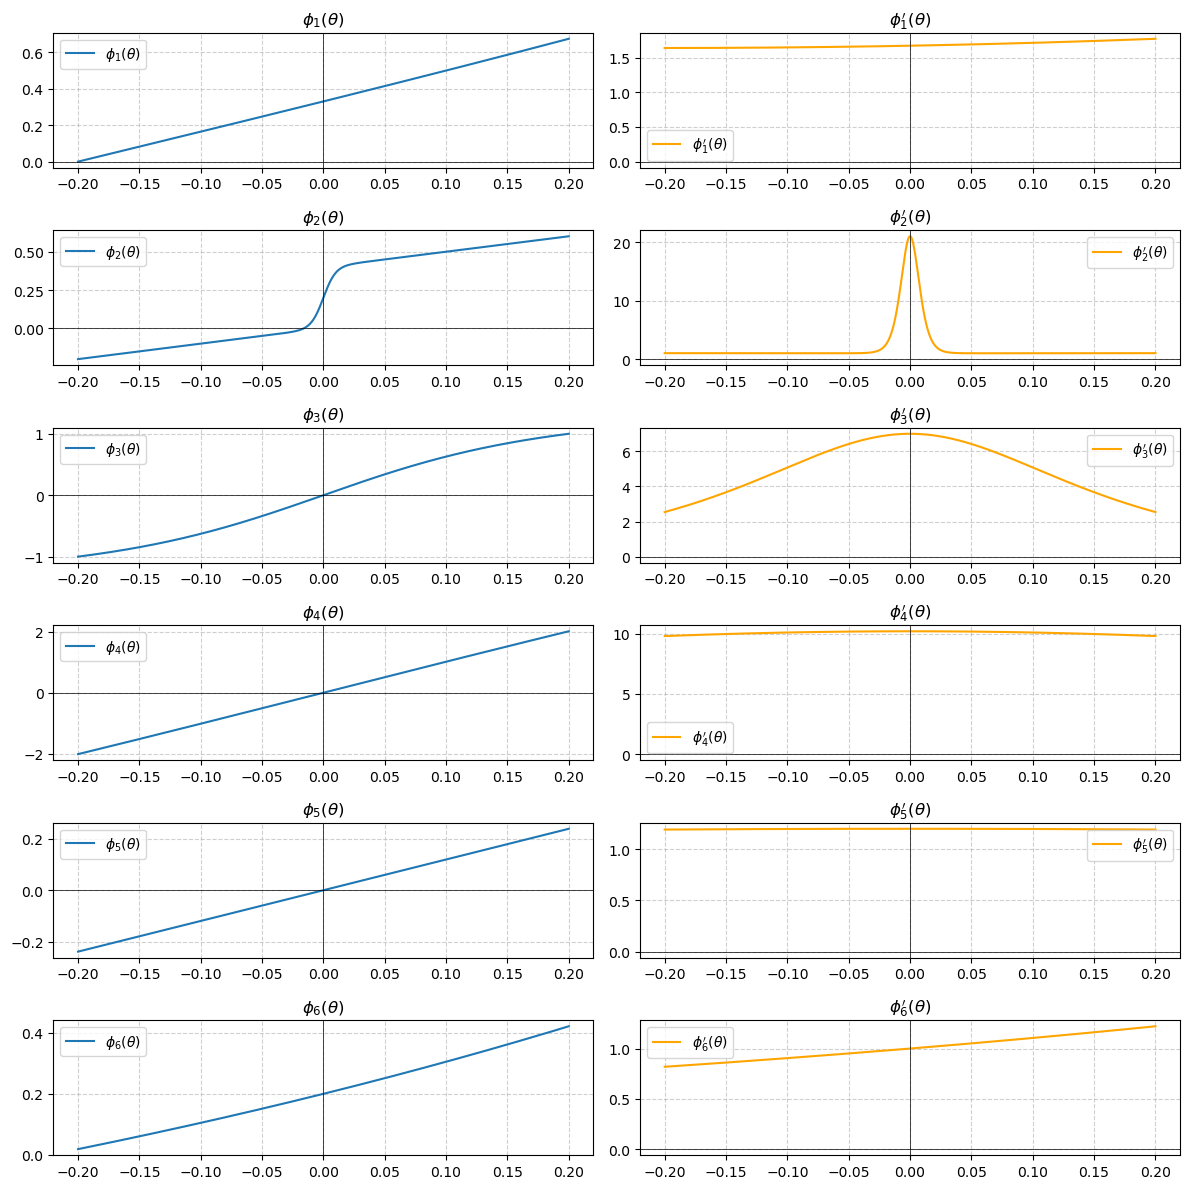

In [143]:

import matplotlib.pyplot as plt

# -------------------------
# Define functions & derivatives
# -------------------------
def phi1(theta, eps=0.2):
    return np.exp(theta) - np.exp(-theta - 2*eps)

def dphi1(theta, eps=0.2):
    return np.exp(theta) + np.exp(-theta - 2*eps)

def phi2(theta, eps=0.2, k=1.0):
    return np.sinh(theta) + eps*(1 + np.tanh(k*theta))

def dphi2(theta, eps=0.2, k=1.0):
    return np.cosh(theta) + eps*k*(1 - np.tanh(k*theta)**2)

def phi3(theta, eps=0.2):
    return theta*(1+eps)/np.sqrt(theta**2 + eps**2) + eps*np.tanh(theta/eps)

def dphi3(theta, eps=0.2):
    term1 = (1+eps)*(eps**2)/(theta**2 + eps**2)**1.5
    term2 = 1/np.cosh(theta/eps)**2
    return term1 + term2

def phi4(theta, eps=0.2, c=10.0):
    return (c+eps)*np.tanh(theta)
def dphi4(theta, eps=0.2, c=10.0):
    return (c+eps)/np.cosh(theta)**2

def phi5(theta, eps=0.2):
    return theta + eps*np.tanh(theta)
def dphi5(theta, eps=0.2):
    return 1 + eps/np.cosh(theta)**2

def phi6(theta, eps=0.2):
    return np.exp(theta) + eps - 1

def dphi6(theta, eps=0.2):
    return np.exp(theta)

# -------------------------
# Plot settings
# -------------------------
theta = np.linspace(-0.2, 0.2, 1200)
eps = 0.2
k = 100.0

fig, axes = plt.subplots(6, 2, figsize=(12, 12))

# φ1
axes[0,0].plot(theta, phi1(theta, eps), label=r'$\phi_1(\theta)$')
axes[0,1].plot(theta, dphi1(theta, eps), color="orange", label=r"$\phi_1'(\theta)$")

# φ2
axes[1,0].plot(theta, phi2(theta, eps, k), label=r'$\phi_2(\theta)$')
axes[1,1].plot(theta, dphi2(theta, eps, k), color="orange", label=r"$\phi_2'(\theta)$")

# φ3
axes[2,0].plot(theta, phi3(theta, eps), label=r'$\phi_3(\theta)$')
axes[2,1].plot(theta, dphi3(theta, eps), color="orange", label=r"$\phi_3'(\theta)$")

# φ4
axes[3,0].plot(theta, phi4(theta, eps), label=r'$\phi_4(\theta)$')
axes[3,1].plot(theta, dphi4(theta, eps), color="orange", label=r"$\phi_4'(\theta)$")

# φ5
axes[4,0].plot(theta, phi5(theta, eps), label=r'$\phi_5(\theta)$')
axes[4,1].plot(theta, dphi5(theta, eps), color="orange", label=r"$\phi_5'(\theta)$")

# φ5
axes[5,0].plot(theta, phi6(theta, eps), label=r'$\phi_6(\theta)$')
axes[5,1].plot(theta, dphi6(theta, eps), color="orange", label=r"$\phi_6'(\theta)$")

# Formatting
for axrow in axes:
    for ax in axrow:
        ax.axhline(0, color="k", linewidth=0.5)
        ax.axvline(0, color="k", linewidth=0.5)
        ax.legend()
        ax.grid(True, linestyle="--", alpha=0.6)

axes[0,0].set_title(r'$\phi_1(\theta)$')
axes[0,1].set_title(r"$\phi_1'(\theta)$")
axes[1,0].set_title(r'$\phi_2(\theta)$')
axes[1,1].set_title(r"$\phi_2'(\theta)$")
axes[2,0].set_title(r'$\phi_3(\theta)$')
axes[2,1].set_title(r"$\phi_3'(\theta)$")
axes[3,0].set_title(r'$\phi_4(\theta)$')
axes[3,1].set_title(r"$\phi_4'(\theta)$")
axes[4,0].set_title(r'$\phi_5(\theta)$')
axes[4,1].set_title(r"$\phi_5'(\theta)$")
axes[5,0].set_title(r'$\phi_6(\theta)$')
axes[5,1].set_title(r"$\phi_6'(\theta)$")

plt.tight_layout()
plt.show()


Creating comprehensive visualization...
Creating summary comparison...


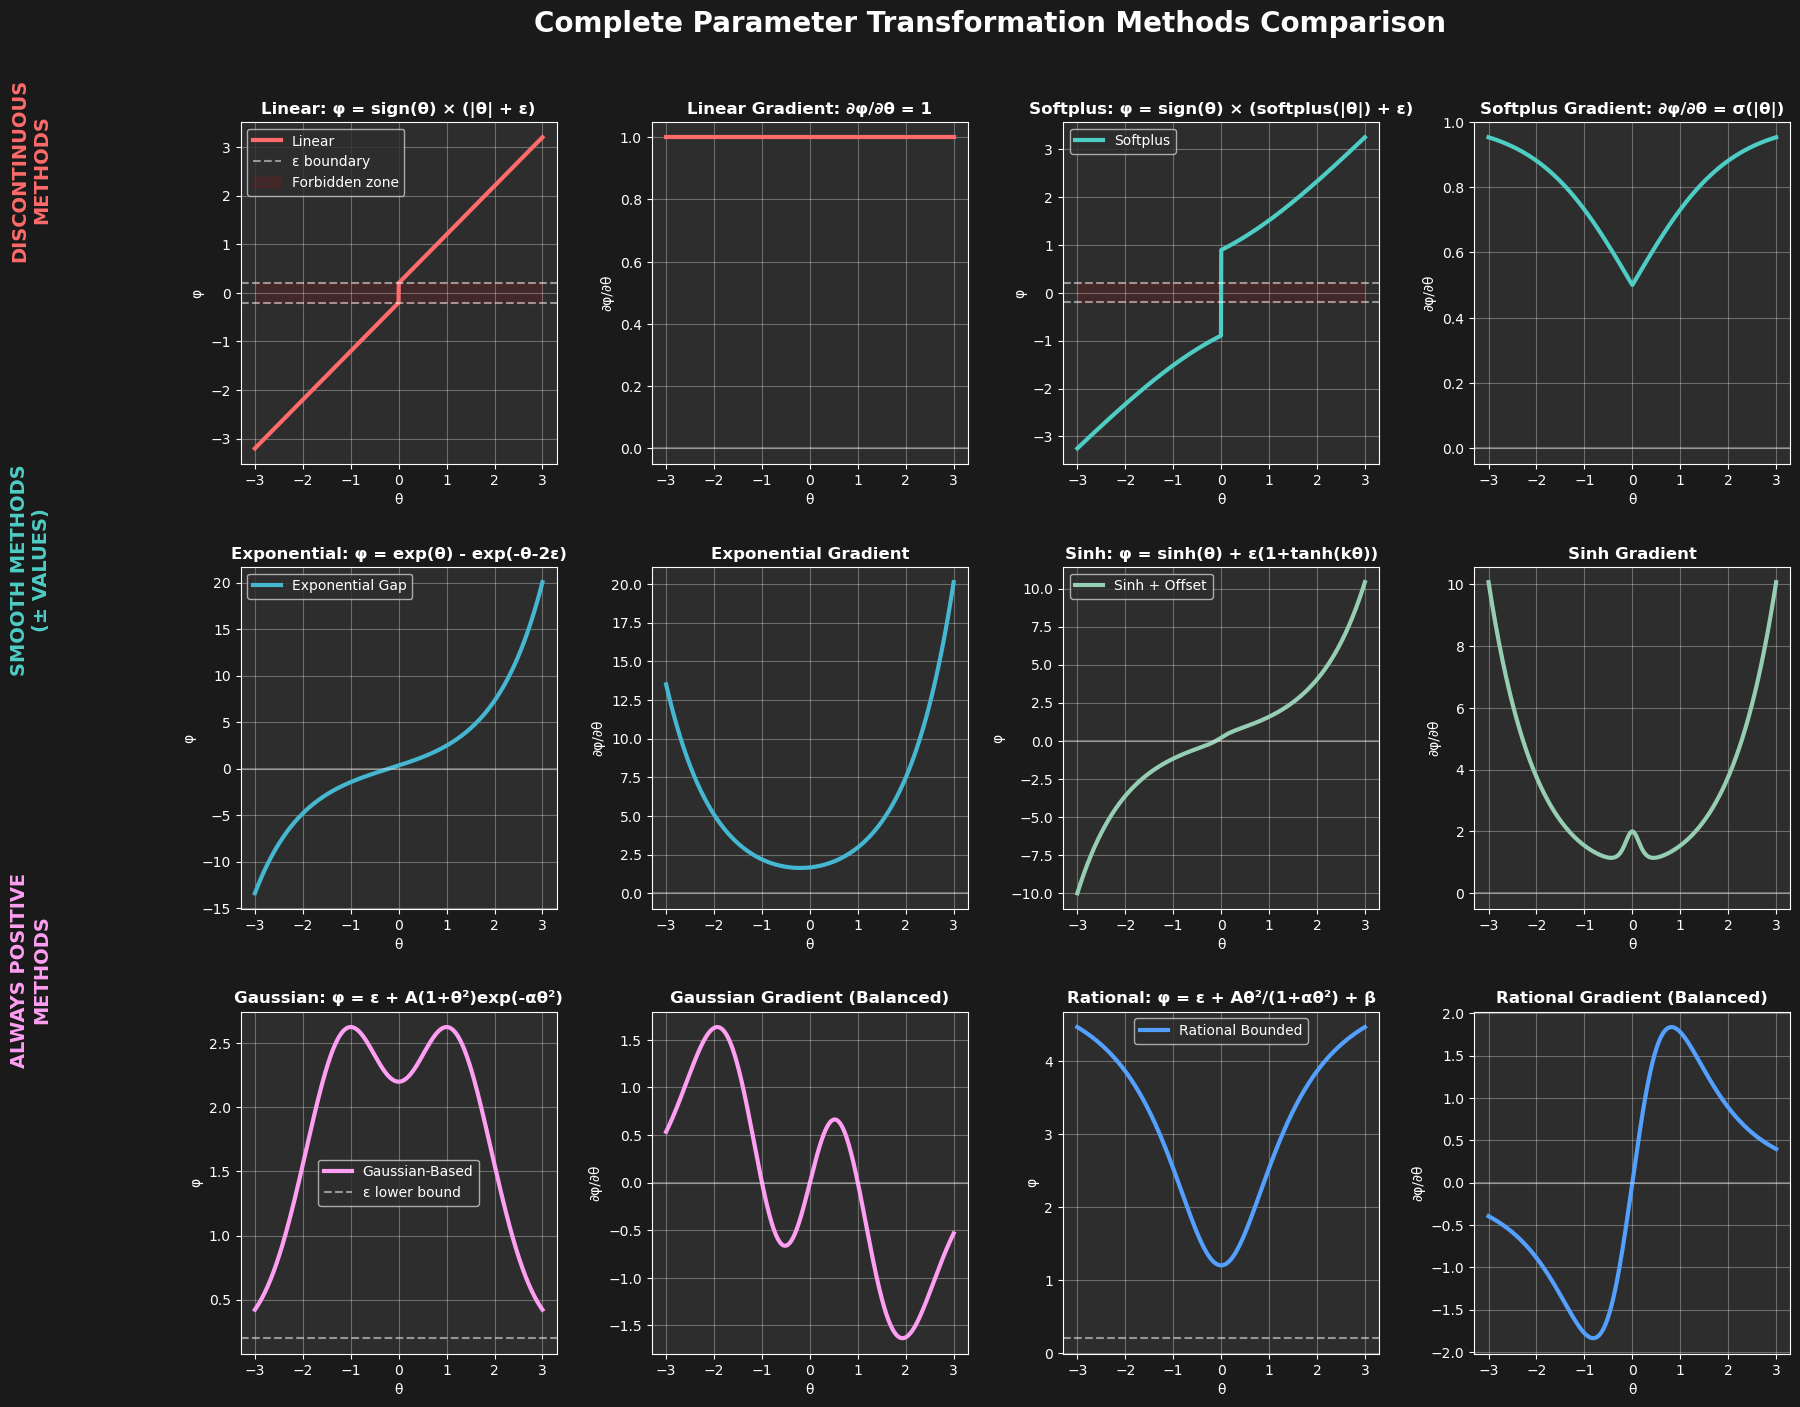

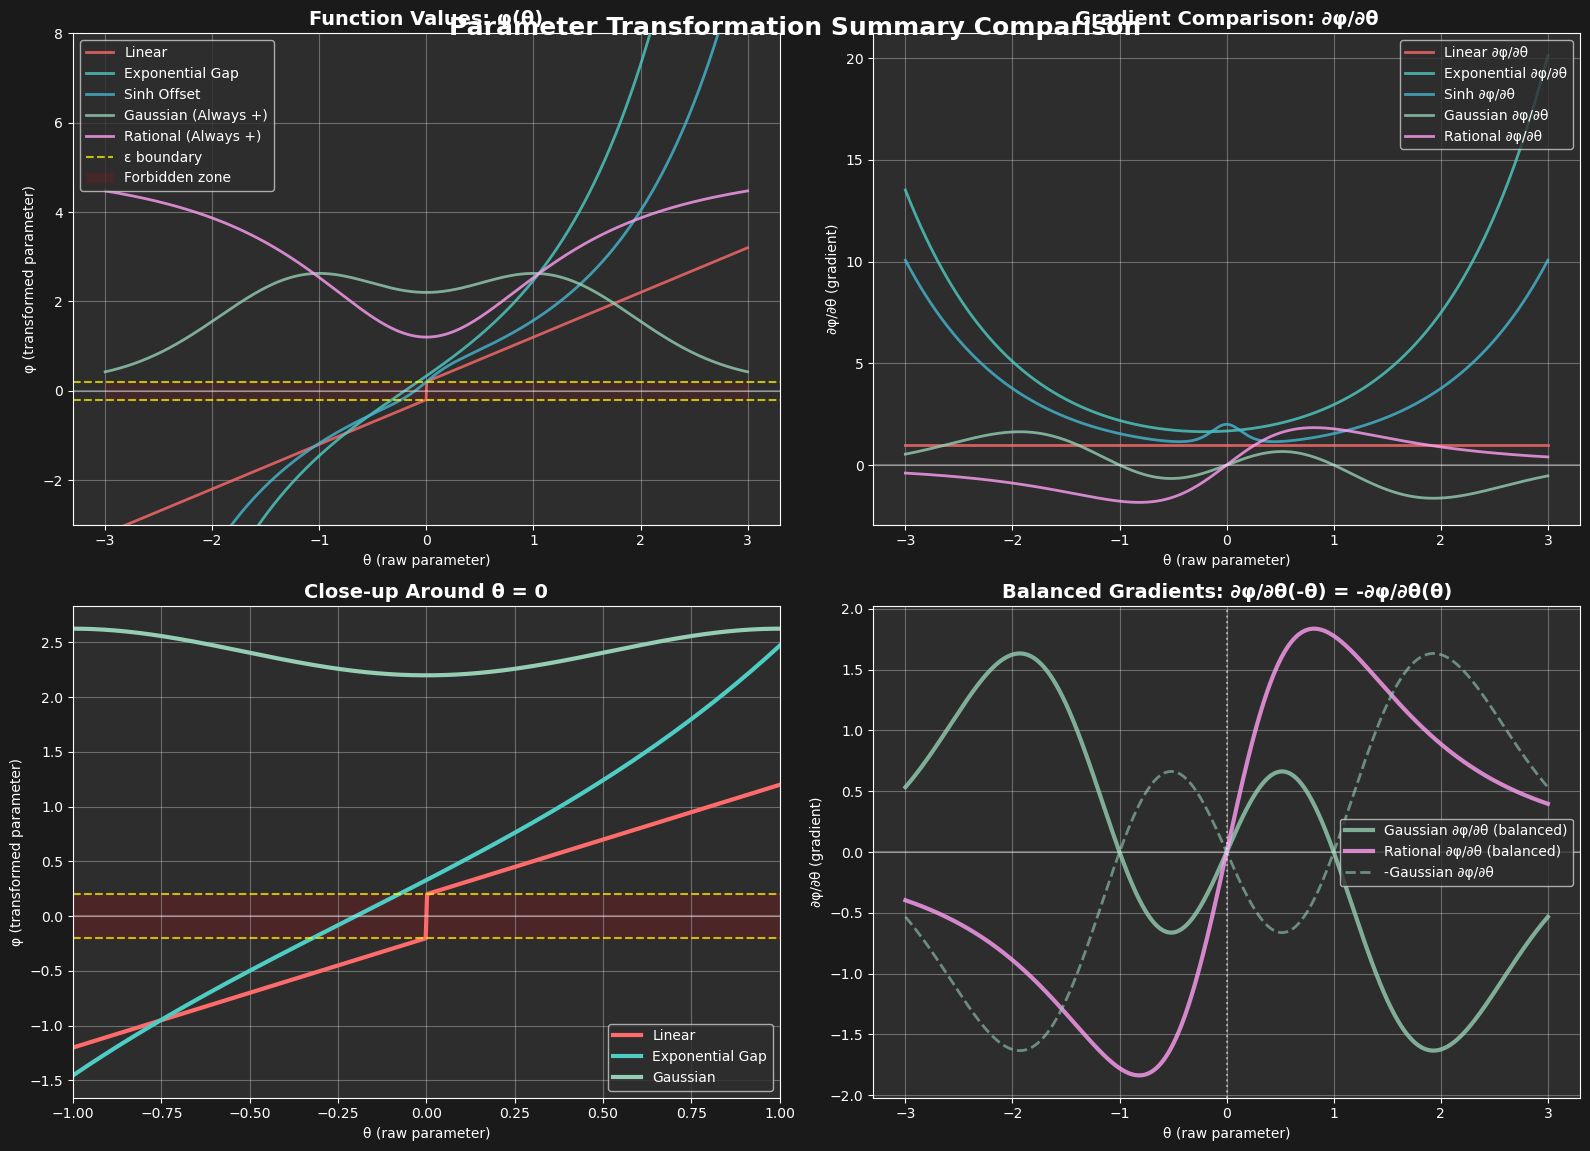


Visualization complete!

Key observations:
1. Discontinuous methods have jumps at θ=0
2. Smooth methods provide continuous transitions
3. Always-positive methods encode 'sign' while staying above ε
4. Balanced methods have antisymmetric gradients: ∂φ/∂θ(-θ) = -∂φ/∂θ(θ)
5. Gaussian and Rational methods provide the best balance of all desired properties


In [144]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')

# Set up the plotting style
plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = '#1a1a1a'
plt.rcParams['axes.facecolor'] = '#2d2d2d'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

class ParameterTransformations:
    def __init__(self, epsilon=0.2, A=2.0, alpha=0.5, beta=1.0, k=5.0):
        self.epsilon = epsilon
        self.A = A
        self.alpha = alpha
        self.beta = beta
        self.k = k
        
    def softplus(self, x):
        # Numerically stable softplus
        return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)
    
    def safe_sign(self, x):
        """Handle sign function, avoiding exactly zero"""
        return np.where(x >= 0, 1, -1)
    
    # ===== DISCONTINUOUS METHODS =====
    def linear_transform(self, theta):
        """Original linear method: φ = sign(θ) × (|θ| + ε)"""
        return self.safe_sign(theta) * (np.abs(theta) + self.epsilon)
    
    def softplus_transform(self, theta):
        """Softplus method: φ = sign(θ) × (softplus(|θ|) + ε)"""
        return self.safe_sign(theta) * (self.softplus(np.abs(theta)) + self.epsilon)
    
    # ===== SMOOTH METHODS (CAN GO NEGATIVE) =====
    def exponential_gap(self, theta):
        """Exponential gap: φ = exp(θ) - exp(-θ - 2ε)"""
        return np.exp(theta) - np.exp(-theta - 2*self.epsilon)
    
    def sinh_offset(self, theta):
        """Sinh + offset: φ = sinh(θ) + ε(1 + tanh(kθ))"""
        return np.sinh(theta) + self.epsilon * (1 + np.tanh(self.k * theta))
    
    def rational_tanh(self, theta):
        """Rational + tanh: φ = θ(1+ε)/√(θ²+ε²) + ε·tanh(θ/ε)"""
        term1 = theta * (1 + self.epsilon) / np.sqrt(theta**2 + self.epsilon**2)
        term2 = self.epsilon * np.tanh(theta / self.epsilon)
        return term1 + term2
    
    # ===== ALWAYS POSITIVE METHODS =====
    def gaussian_based(self, theta):
        """Gaussian-based: φ = ε + A*(1 + θ²)*exp(-α*θ²)"""
        return self.epsilon + self.A * (1 + theta**2) * np.exp(-self.alpha * theta**2)
    
    def rational_bounded(self, theta):
        """Rational bounded: φ = ε + A*θ²/(1 + α*θ²) + β"""
        return self.epsilon + self.A * theta**2 / (1 + self.alpha * theta**2) + self.beta
    
    def hybrid_sech(self, theta):
        """Hybrid sech²: φ = ε + A + β*tanh(θ) + α*sech²(θ)"""
        sech = 1 / np.cosh(theta)
        return self.epsilon + self.A + self.beta * np.tanh(theta) + self.alpha * sech**2
    
    def numerical_derivative(self, func, theta, h=1e-6):
        """Compute numerical derivative"""
        return (func(theta + h) - func(theta - h)) / (2 * h)

def create_comprehensive_visualization():
    # Create parameter transformation instance
    transformer = ParameterTransformations(epsilon=0.2, A=2.0, alpha=0.5, beta=1.0, k=5.0)
    
    # Generate theta values
    theta = np.linspace(-3, 3, 1000)
    
    # Avoid exactly zero for discontinuous functions
    theta_safe = np.where(np.abs(theta) < 1e-10, np.sign(theta) * 1e-10, theta)
    
    # Create the main figure with subplots
    fig = plt.figure(figsize=(20, 16))
    gs = GridSpec(3, 4, figure=fig, hspace=0.3, wspace=0.3)
    
    # Define colors for each method
    colors = {
        'linear': '#FF6B6B',
        'softplus': '#4ECDC4', 
        'exponential': '#45B7D1',
        'sinh': '#96CEB4',
        'rational_tanh': '#FECA57',
        'gaussian': '#FF9FF3',
        'rational_bounded': '#54A0FF',
        'hybrid': '#5F27CD'
    }
    
    # === ROW 1: DISCONTINUOUS METHODS ===
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    
    # Linear transform
    phi_linear = transformer.linear_transform(theta_safe)
    grad_linear = np.ones_like(theta) * np.where(theta >= 0, 1, 1)  # Always 1
    
    ax1.plot(theta, phi_linear, color=colors['linear'], linewidth=3, label='Linear')
    ax1.axhline(y=transformer.epsilon, color='white', linestyle='--', alpha=0.5, label='ε boundary')
    ax1.axhline(y=-transformer.epsilon, color='white', linestyle='--', alpha=0.5)
    ax1.fill_between([-3, 3], [-transformer.epsilon, -transformer.epsilon], 
                     [transformer.epsilon, transformer.epsilon], alpha=0.1, color='red', label='Forbidden zone')
    ax1.set_title('Linear: φ = sign(θ) × (|θ| + ε)', fontsize=12, fontweight='bold')
    ax1.set_xlabel('θ')
    ax1.set_ylabel('φ')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(theta, grad_linear, color=colors['linear'], linewidth=3)
    ax2.axhline(y=0, color='white', linestyle='-', alpha=0.3)
    ax2.set_title('Linear Gradient: ∂φ/∂θ = 1', fontsize=12, fontweight='bold')
    ax2.set_xlabel('θ')
    ax2.set_ylabel('∂φ/∂θ')
    ax2.grid(True, alpha=0.3)
    
    # Softplus transform
    ax3 = fig.add_subplot(gs[0, 2])
    ax4 = fig.add_subplot(gs[0, 3])
    
    phi_softplus = transformer.softplus_transform(theta_safe)
    grad_softplus = transformer.numerical_derivative(transformer.softplus_transform, theta)
    
    ax3.plot(theta, phi_softplus, color=colors['softplus'], linewidth=3, label='Softplus')
    ax3.axhline(y=transformer.epsilon, color='white', linestyle='--', alpha=0.5)
    ax3.axhline(y=-transformer.epsilon, color='white', linestyle='--', alpha=0.5)
    ax3.fill_between([-3, 3], [-transformer.epsilon, -transformer.epsilon], 
                     [transformer.epsilon, transformer.epsilon], alpha=0.1, color='red')
    ax3.set_title('Softplus: φ = sign(θ) × (softplus(|θ|) + ε)', fontsize=12, fontweight='bold')
    ax3.set_xlabel('θ')
    ax3.set_ylabel('φ')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    ax4.plot(theta, grad_softplus, color=colors['softplus'], linewidth=3)
    ax4.axhline(y=0, color='white', linestyle='-', alpha=0.3)
    ax4.set_title('Softplus Gradient: ∂φ/∂θ = σ(|θ|)', fontsize=12, fontweight='bold')
    ax4.set_xlabel('θ')
    ax4.set_ylabel('∂φ/∂θ')
    ax4.grid(True, alpha=0.3)
    
    # === ROW 2: SMOOTH METHODS (CAN GO NEGATIVE) ===
    ax5 = fig.add_subplot(gs[1, 0])
    ax6 = fig.add_subplot(gs[1, 1])
    ax7 = fig.add_subplot(gs[1, 2])
    ax8 = fig.add_subplot(gs[1, 3])
    
    # Exponential gap
    phi_exp = transformer.exponential_gap(theta)
    grad_exp = transformer.numerical_derivative(transformer.exponential_gap, theta)
    
    ax5.plot(theta, phi_exp, color=colors['exponential'], linewidth=3, label='Exponential Gap')
    ax5.axhline(y=0, color='white', linestyle='-', alpha=0.3)
    ax5.set_title('Exponential: φ = exp(θ) - exp(-θ-2ε)', fontsize=12, fontweight='bold')
    ax5.set_xlabel('θ')
    ax5.set_ylabel('φ')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    ax6.plot(theta, grad_exp, color=colors['exponential'], linewidth=3)
    ax6.axhline(y=0, color='white', linestyle='-', alpha=0.3)
    ax6.set_title('Exponential Gradient', fontsize=12, fontweight='bold')
    ax6.set_xlabel('θ')
    ax6.set_ylabel('∂φ/∂θ')
    ax6.grid(True, alpha=0.3)
    
    # Sinh + offset
    phi_sinh = transformer.sinh_offset(theta)
    grad_sinh = transformer.numerical_derivative(transformer.sinh_offset, theta)
    
    ax7.plot(theta, phi_sinh, color=colors['sinh'], linewidth=3, label='Sinh + Offset')
    ax7.axhline(y=0, color='white', linestyle='-', alpha=0.3)
    ax7.set_title('Sinh: φ = sinh(θ) + ε(1+tanh(kθ))', fontsize=12, fontweight='bold')
    ax7.set_xlabel('θ')
    ax7.set_ylabel('φ')
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    
    ax8.plot(theta, grad_sinh, color=colors['sinh'], linewidth=3)
    ax8.axhline(y=0, color='white', linestyle='-', alpha=0.3)
    ax8.set_title('Sinh Gradient', fontsize=12, fontweight='bold')
    ax8.set_xlabel('θ')
    ax8.set_ylabel('∂φ/∂θ')
    ax8.grid(True, alpha=0.3)
    
    # === ROW 3: ALWAYS POSITIVE METHODS ===
    ax9 = fig.add_subplot(gs[2, 0])
    ax10 = fig.add_subplot(gs[2, 1])
    ax11 = fig.add_subplot(gs[2, 2])
    ax12 = fig.add_subplot(gs[2, 3])
    
    # Gaussian-based
    phi_gaussian = transformer.gaussian_based(theta)
    grad_gaussian = transformer.numerical_derivative(transformer.gaussian_based, theta)
    
    ax9.plot(theta, phi_gaussian, color=colors['gaussian'], linewidth=3, label='Gaussian-Based')
    ax9.axhline(y=transformer.epsilon, color='white', linestyle='--', alpha=0.5, label='ε lower bound')
    ax9.set_title('Gaussian: φ = ε + A(1+θ²)exp(-αθ²)', fontsize=12, fontweight='bold')
    ax9.set_xlabel('θ')
    ax9.set_ylabel('φ')
    ax9.legend()
    ax9.grid(True, alpha=0.3)
    
    ax10.plot(theta, grad_gaussian, color=colors['gaussian'], linewidth=3)
    ax10.axhline(y=0, color='white', linestyle='-', alpha=0.3)
    ax10.set_title('Gaussian Gradient (Balanced)', fontsize=12, fontweight='bold')
    ax10.set_xlabel('θ')
    ax10.set_ylabel('∂φ/∂θ')
    ax10.grid(True, alpha=0.3)
    
    # Rational bounded
    phi_rational = transformer.rational_bounded(theta)
    grad_rational = transformer.numerical_derivative(transformer.rational_bounded, theta)
    
    ax11.plot(theta, phi_rational, color=colors['rational_bounded'], linewidth=3, label='Rational Bounded')
    ax11.axhline(y=transformer.epsilon, color='white', linestyle='--', alpha=0.5)
    ax11.set_title('Rational: φ = ε + Aθ²/(1+αθ²) + β', fontsize=12, fontweight='bold')
    ax11.set_xlabel('θ')
    ax11.set_ylabel('φ')
    ax11.legend()
    ax11.grid(True, alpha=0.3)
    
    ax12.plot(theta, grad_rational, color=colors['rational_bounded'], linewidth=3)
    ax12.axhline(y=0, color='white', linestyle='-', alpha=0.3)
    ax12.set_title('Rational Gradient (Balanced)', fontsize=12, fontweight='bold')
    ax12.set_xlabel('θ')
    ax12.set_ylabel('∂φ/∂θ')
    ax12.grid(True, alpha=0.3)
    
    # Add main title
    fig.suptitle('Complete Parameter Transformation Methods Comparison', 
                fontsize=20, fontweight='bold', y=0.95)
    
    # Add method type labels
    fig.text(0.02, 0.85, 'DISCONTINUOUS\nMETHODS', rotation=90, fontsize=14, 
             fontweight='bold', ha='center', va='center', color='#FF6B6B')
    fig.text(0.02, 0.60, 'SMOOTH METHODS\n(± VALUES)', rotation=90, fontsize=14, 
             fontweight='bold', ha='center', va='center', color='#4ECDC4')
    fig.text(0.02, 0.35, 'ALWAYS POSITIVE\nMETHODS', rotation=90, fontsize=14, 
             fontweight='bold', ha='center', va='center', color='#FF9FF3')
    
    plt.tight_layout()
    return fig

def create_comparison_summary():
    """Create a summary comparison plot"""
    transformer = ParameterTransformations(epsilon=0.2, A=2.0, alpha=0.5, beta=1.0, k=5.0)
    theta = np.linspace(-3, 3, 1000)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.patch.set_facecolor('#1a1a1a')
    
    # Colors
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FF9FF3']
    
    # Plot 1: All function values
    ax1.plot(theta, transformer.linear_transform(theta), color=colors[0], linewidth=2, label='Linear', alpha=0.8)
    ax1.plot(theta, transformer.exponential_gap(theta), color=colors[1], linewidth=2, label='Exponential Gap', alpha=0.8)
    ax1.plot(theta, transformer.sinh_offset(theta), color=colors[2], linewidth=2, label='Sinh Offset', alpha=0.8)
    ax1.plot(theta, transformer.gaussian_based(theta), color=colors[3], linewidth=2, label='Gaussian (Always +)', alpha=0.8)
    ax1.plot(theta, transformer.rational_bounded(theta), color=colors[4], linewidth=2, label='Rational (Always +)', alpha=0.8)
    
    ax1.axhline(y=0, color='white', linestyle='-', alpha=0.3)
    ax1.axhline(y=transformer.epsilon, color='yellow', linestyle='--', alpha=0.7, label='ε boundary')
    ax1.axhline(y=-transformer.epsilon, color='yellow', linestyle='--', alpha=0.7)
    ax1.fill_between([-3, 3], [-transformer.epsilon, -transformer.epsilon], 
                     [transformer.epsilon, transformer.epsilon], alpha=0.1, color='red', label='Forbidden zone')
    
    ax1.set_title('Function Values: φ(θ)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('θ (raw parameter)')
    ax1.set_ylabel('φ (transformed parameter)')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(-3, 8)
    
    # Plot 2: All gradients
    grad_linear = np.ones_like(theta)
    grad_exp = transformer.numerical_derivative(transformer.exponential_gap, theta)
    grad_sinh = transformer.numerical_derivative(transformer.sinh_offset, theta)
    grad_gaussian = transformer.numerical_derivative(transformer.gaussian_based, theta)
    grad_rational = transformer.numerical_derivative(transformer.rational_bounded, theta)
    
    ax2.plot(theta, grad_linear, color=colors[0], linewidth=2, label='Linear ∂φ/∂θ', alpha=0.8)
    ax2.plot(theta, grad_exp, color=colors[1], linewidth=2, label='Exponential ∂φ/∂θ', alpha=0.8)
    ax2.plot(theta, grad_sinh, color=colors[2], linewidth=2, label='Sinh ∂φ/∂θ', alpha=0.8)
    ax2.plot(theta, grad_gaussian, color=colors[3], linewidth=2, label='Gaussian ∂φ/∂θ', alpha=0.8)
    ax2.plot(theta, grad_rational, color=colors[4], linewidth=2, label='Rational ∂φ/∂θ', alpha=0.8)
    
    ax2.axhline(y=0, color='white', linestyle='-', alpha=0.3)
    ax2.set_title('Gradient Comparison: ∂φ/∂θ', fontsize=14, fontweight='bold')
    ax2.set_xlabel('θ (raw parameter)')
    ax2.set_ylabel('∂φ/∂θ (gradient)')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Close-up around zero
    theta_zoom = np.linspace(-1, 1, 500)
    ax3.plot(theta_zoom, transformer.linear_transform(theta_zoom), color=colors[0], linewidth=3, label='Linear')
    ax3.plot(theta_zoom, transformer.exponential_gap(theta_zoom), color=colors[1], linewidth=3, label='Exponential Gap')
    ax3.plot(theta_zoom, transformer.gaussian_based(theta_zoom), color=colors[3], linewidth=3, label='Gaussian')
    
    ax3.axhline(y=0, color='white', linestyle='-', alpha=0.3)
    ax3.axhline(y=transformer.epsilon, color='yellow', linestyle='--', alpha=0.7)
    ax3.axhline(y=-transformer.epsilon, color='yellow', linestyle='--', alpha=0.7)
    ax3.fill_between([-1, 1], [-transformer.epsilon, -transformer.epsilon], 
                     [transformer.epsilon, transformer.epsilon], alpha=0.15, color='red')
    
    ax3.set_title('Close-up Around θ = 0', fontsize=14, fontweight='bold')
    ax3.set_xlabel('θ (raw parameter)')
    ax3.set_ylabel('φ (transformed parameter)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim(-1, 1)
    
    # Plot 4: Gradient properties
    # Show antisymmetric property for balanced methods
    ax4.plot(theta, grad_gaussian, color=colors[3], linewidth=3, label='Gaussian ∂φ/∂θ (balanced)', alpha=0.8)
    ax4.plot(theta, grad_rational, color=colors[4], linewidth=3, label='Rational ∂φ/∂θ (balanced)', alpha=0.8)
    ax4.plot(theta, -grad_gaussian, color=colors[3], linewidth=2, linestyle='--', alpha=0.6, label='-Gaussian ∂φ/∂θ')
    
    ax4.axhline(y=0, color='white', linestyle='-', alpha=0.3)
    ax4.axvline(x=0, color='white', linestyle=':', alpha=0.5)
    ax4.set_title('Balanced Gradients: ∂φ/∂θ(-θ) = -∂φ/∂θ(θ)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('θ (raw parameter)')
    ax4.set_ylabel('∂φ/∂θ (gradient)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle('Parameter Transformation Summary Comparison', fontsize=18, fontweight='bold', y=0.95)
    plt.tight_layout()
    return fig

# Create and display the visualizations
if __name__ == "__main__":
    print("Creating comprehensive visualization...")
    fig1 = create_comprehensive_visualization()
    
    print("Creating summary comparison...")
    fig2 = create_comparison_summary()
    
    # Display the plots
    plt.show()
    
    print("\nVisualization complete!")
    print("\nKey observations:")
    print("1. Discontinuous methods have jumps at θ=0")
    print("2. Smooth methods provide continuous transitions")
    print("3. Always-positive methods encode 'sign' while staying above ε")
    print("4. Balanced methods have antisymmetric gradients: ∂φ/∂θ(-θ) = -∂φ/∂θ(θ)")
    print("5. Gaussian and Rational methods provide the best balance of all desired properties")

In [ ]:

class Step_1(nn.Module):
    """
    A fully customizable layer that transforms position and velocity:
    X = a * x + c1
    U = (1/a) * u - γ * ∂G/∂x + c2
    where G(x,t) is a customizable MLP network and a, c1, γ, c2 are trainable parameters.
    
    Input: (x, u, t) 
    Output: (X, U, t) where X and U are transformed
    """
    
    def __init__(
        self,
        # MLP Architecture parameters
        hidden_dims: Union[int, List[int]] = 32,
        n_hidden_layers: int = 2,
        
        # Activation parameters
        activation: str = 'tanh',
        activation_params: Optional[dict] = None,
        final_activation: Optional[str] = None,
        
        # Initialization parameters
        weight_init: str = 'xavier_uniform',
        weight_init_params: Optional[dict] = None,
        bias_init: str = 'zeros',
        bias_init_value: float = 0.0,
        
        # Architectural choices
        use_bias: bool = True,
        
        # Input/Output parameters
        input_dim: int = 2,  # x and t
        output_dim: int = 1,  # scalar G
        
        # Trainable parameter constraints
        a_min: float = 0.1,  # Minimum value for a to prevent zero
    ):
        """
        Initialize the velocity transformation layer with trainable parameters.
        """
        super(Step_1, self).__init__()
        
        # Initialize trainable parameters
        self.a_raw = nn.Parameter(torch.tensor(0.0))  # Will use exp(a_raw) to ensure positive
        self.c1 = nn.Parameter(torch.tensor(0.0))
        self.gamma = nn.Parameter(torch.tensor(1.0))
        self.c2 = nn.Parameter(torch.tensor(0.0))
        
        # Store minimum value for a
        self.a_min = a_min
        
        # Process hidden dimensions
        if isinstance(hidden_dims, int):
            self.hidden_dims = [hidden_dims] * n_hidden_layers
        else:
            self.hidden_dims = hidden_dims
            
        # Build the MLP
        self.G_network = self._build_mlp(
            input_dim=input_dim,
            output_dim=output_dim,
            hidden_dims=self.hidden_dims,
            activation=activation,
            activation_params=activation_params,
            final_activation=final_activation,
            use_bias=use_bias,
        )
        
        # Initialize weights
        self._initialize_weights(
            weight_init=weight_init,
            weight_init_params=weight_init_params,
            bias_init=bias_init,
            bias_init_value=bias_init_value
        )
    
    @property
    def a(self):
        """Compute a from a_raw, ensuring it's always positive and bounded away from zero."""
        # exp(0) = 1, so initialization gives a = 1
        # Using exp ensures a > 0 always
        # Adding a_min ensures a >= a_min
        return torch.exp(self.a_raw) + self.a_min - 1.0
    
    def _get_activation(self, activation_name: str, params: Optional[dict] = None):
        """Get activation function by name."""
        params = params or {}
        
        activations = {
            'tanh': nn.Tanh,
            'sigmoid': nn.Sigmoid,
            'elu': lambda: nn.ELU(**params),
            'selu': nn.SELU,
            'gelu': nn.GELU,
            'softplus': lambda: nn.Softplus(**params),
            'swish': nn.SiLU,
            'mish': nn.Mish,
            'identity': nn.Identity,
            'none': nn.Identity,
        }
        
        if activation_name.lower() not in activations:
            raise ValueError(f"Unknown activation: {activation_name}")
        
        activation = activations[activation_name.lower()]
        return activation() if callable(activation) else activation(**params)
    
    def _build_mlp(
        self, input_dim, output_dim, hidden_dims, activation, activation_params,
        final_activation, use_bias
    ):
        """Build the MLP network with specified configuration."""
        layers = []
        
        # Determine layer dimensions
        all_dims = [input_dim] + hidden_dims + [output_dim]
        
        # Build each layer
        for i in range(len(all_dims) - 1):
            in_dim = all_dims[i]
            out_dim = all_dims[i + 1]
            is_last_layer = (i == len(all_dims) - 2)
            
            # Linear layer
            linear = nn.Linear(in_dim, out_dim, bias=use_bias)
            layers.append(linear)
            
            # Add activation
            if is_last_layer:
                if final_activation is not None:
                    layers.append(self._get_activation(final_activation, activation_params))
            else:
                layers.append(self._get_activation(activation, activation_params))
        
        return nn.Sequential(*layers)
    
    def _initialize_weights(self, weight_init, weight_init_params, bias_init, bias_init_value):
        """Initialize weights and biases according to specifications."""
        weight_init_params = weight_init_params or {}
        
        def init_weights(m):
            if isinstance(m, nn.Linear):
                # Initialize weights
                if weight_init == 'xavier_uniform':
                    init.xavier_uniform_(m.weight, **weight_init_params)
                elif weight_init == 'xavier_normal':
                    init.xavier_normal_(m.weight, **weight_init_params)
                elif weight_init == 'kaiming_uniform':
                    init.kaiming_uniform_(m.weight, **weight_init_params)
                elif weight_init == 'kaiming_normal':
                    init.kaiming_normal_(m.weight, **weight_init_params)
                elif weight_init == 'normal':
                    init.normal_(m.weight, **weight_init_params)
                elif weight_init == 'uniform':
                    init.uniform_(m.weight, **weight_init_params)
                elif weight_init == 'orthogonal':
                    init.orthogonal_(m.weight, **weight_init_params)
                
                # Initialize biases
                if m.bias is not None:
                    if bias_init == 'zeros':
                        init.zeros_(m.bias)
                    elif bias_init == 'ones':
                        init.ones_(m.bias)
                    elif bias_init == 'uniform':
                        init.uniform_(m.bias, -bias_init_value, bias_init_value)
                    elif bias_init == 'normal':
                        init.normal_(m.bias, std=bias_init_value)
                    elif bias_init == 'constant':
                        init.constant_(m.bias, bias_init_value)
        
        self.G_network.apply(init_weights)
    
    def compute_G_and_gradient(self, x, t):
        """
        Compute G(x,t) and its gradient with respect to x.
        
        Args:
            x: Position tensor of shape (batch_size,) or (batch_size, 1)
            t: Time tensor of shape (batch_size,) or (batch_size, 1)
            
        Returns:
            dG_dx: The partial derivative ∂G/∂x
        """
        # Ensure x requires gradient for autograd to work
        x = x.requires_grad_(True)
        
        # Reshape inputs if needed
        if x.dim() == 1:
            x = x.unsqueeze(1)
        if t.dim() == 1:
            t = t.unsqueeze(1)
        
        # Stack inputs for the MLP
        mlp_input = torch.cat([x, t], dim=1)
        
        # Forward pass through the MLP
        G = self.G_network(mlp_input)
        
        # Compute the gradient ∂G/∂x
        dG_dx = torch.autograd.grad(
            outputs=G,
            inputs=x,
            grad_outputs=torch.ones_like(G),
            create_graph=self.training,
            retain_graph=False
        )[0]
        
        return dG_dx.squeeze(1)
    
    def forward(self, x, u, t):
        """
        Forward pass of the layer.
        
        Args:
            x: Position tensor of shape (batch_size,)
            u: Velocity tensor of shape (batch_size,)
            t: Time tensor of shape (batch_size,)
            
        Returns:
            X: Transformed position where X = a * x + c1
            U: Transformed velocity where U = (1/a) * u - γ * ∂G/∂x + c2
            t: Unchanged time
        """
        assert x.shape == u.shape == t.shape, "Input shapes must match"
        original_shape = x.shape
        x = x.view(-1)
        u = u.view(-1)
        t = t.view(-1)
        
        # Compute gradient of G with respect to INPUT x (not transformed X)
        dG_dx = self.compute_G_and_gradient(x, t)
        
        # Get current value of a (always positive)
        a_val = self.a
        
        # Transform position: X = a * x + c1
        X = a_val * x + self.c1
        
        # Transform velocity: U = (1/a) * u - γ * ∂G/∂x + c2
        U = (1.0 / a_val) * u - self.gamma * dG_dx + self.c2
        
        return X.view(original_shape), U.view(original_shape), t.view(original_shape)
    
    def get_config(self):
        """Return the configuration of this layer as a dictionary."""
        return {
            'hidden_dims': self.hidden_dims,
            'a': self.a.item(),
            'c1': self.c1.item(),
            'gamma': self.gamma.item(),
            'c2': self.c2.item(),
        }




In [ ]:
# Example usage with various configurations
if __name__ == "__main__":
    complex_layer = Step_1(
        # MLP Architecture parameters
        hidden_dims= [10,40,10],
        n_hidden_layers = None,
        
        # Activation parameters
        activation = 'tanh',
        activation_params = None,
        final_activation = None,
        
        # Initialization parameters
        weight_init = 'xavier_uniform',
        weight_init_params = None,
        bias_init = 'zeros',
        bias_init_value = 0.0,
        

        
        # Architectural choices
        use_bias = True,

        
        # Input/Output parameters
        input_dim = 2,  # x and t
        output_dim = 1,  # scalar G
        
    )
    x_out2, U_out2, t_out2 = complex_layer(batch['x'], batch['u'], batch['t'])
    print(f"Complex layer output: U shape = {U_out2.shape}")
    print(f"Complex layer config: {complex_layer.get_config()}")

Complex layer output: U shape = torch.Size([242])
Complex layer config: {'hidden_dims': [10, 40, 10], 'gradient_scale': 1.0, 'gradient_clipping': None}


In [ ]:
class Step_2(nn.Module):
    """
    A fully customizable layer that transforms position x → X = x + ∂F/∂U
    where F(U,t) is a customizable MLP network.
    
    Input: (x, U, t) 
    Output: (X, U, t) where X = x + ∂F/∂U
    """
    
    def __init__(
        self,
        # MLP Architecture parameters
        hidden_dims: Union[int, List[int]] = 32,
        n_hidden_layers: int = 2,
        
        # Activation parameters
        activation: str = 'tanh',
        activation_params: Optional[dict] = None,
        final_activation: Optional[str] = None,
        
        # Initialization parameters
        weight_init: str = 'xavier_uniform',
        weight_init_params: Optional[dict] = None,
        bias_init: str = 'zeros',
        bias_init_value: float = 0.0,
        
        # Regularization parameters



        
        # Architectural choices
        use_bias: bool = True,

        
        # Input/Output parameters
        input_dim: int = 2,  # x and t
        output_dim: int = 1,  # scalar G
        
    ):
        """
        Initialize the fully customizable velocity transformation layer.
        
        Args:
            hidden_dims: Either an int (same size for all layers) or list of ints for each layer
            n_hidden_layers: Number of hidden layers (ignored if hidden_dims is a list)
            
            activation: Activation function name ('tanh', 'relu', 'leaky_relu', 'elu', 'selu', 
                       'gelu', 'sigmoid', 'softplus', 'swish', 'mish')
            activation_params: Dict of parameters for activation (e.g., {'negative_slope': 0.01} for LeakyReLU)
            final_activation: Optional different activation for the final layer
            
            weight_init: Weight initialization method ('xavier_uniform', 'xavier_normal', 
                        'kaiming_uniform', 'kaiming_normal', 'normal', 'uniform', 'orthogonal')
            weight_init_params: Dict of parameters for initialization
            bias_init: Bias initialization ('zeros', 'ones', 'uniform', 'normal', 'constant')
            bias_init_value: Value for constant bias initialization
            



            
            use_bias: Whether to use bias terms in linear layers

            
            input_dim: Input dimension (default 2 for x and t)
            output_dim: Output dimension (default 1 for scalar G)
            
        """
        super(Step_2, self).__init__()
        

        
        # Process hidden dimensions
        if isinstance(hidden_dims, int):
            self.hidden_dims = [hidden_dims] * n_hidden_layers
        else:
            self.hidden_dims = hidden_dims
            
        # Build the MLP
        self.F_network = self._build_mlp(
            input_dim=input_dim,
            output_dim=output_dim,
            hidden_dims=self.hidden_dims,
            activation=activation,
            activation_params=activation_params,
            final_activation=final_activation,
            use_bias=use_bias,

        )
        
        # Initialize weights
        self._initialize_weights(
            weight_init=weight_init,
            weight_init_params=weight_init_params,
            bias_init=bias_init,
            bias_init_value=bias_init_value
        )
    
    def _get_activation(self, activation_name: str, params: Optional[dict] = None):
        """Get activation function by name."""
        params = params or {}
        
        activations = {
            'relu': nn.ReLU,
            'tanh': nn.Tanh,
            'sigmoid': nn.Sigmoid,
            'leaky_relu': lambda: nn.LeakyReLU(**params),
            'elu': lambda: nn.ELU(**params),
            'selu': nn.SELU,
            'gelu': nn.GELU,
            'softplus': lambda: nn.Softplus(**params),
            'swish': nn.SiLU,  # Swish is same as SiLU
            'mish': nn.Mish,
            'identity': nn.Identity,
            'none': nn.Identity,
        }
        
        if activation_name.lower() not in activations:
            raise ValueError(f"Unknown activation: {activation_name}")
        
        activation = activations[activation_name.lower()]
        return activation() if callable(activation) else activation(**params)
    
    def _build_mlp(
        self, input_dim, output_dim, hidden_dims, activation, activation_params,
        final_activation, use_bias
    ):
        """Build the MLP network with specified configuration."""
        layers = []
        
        # Determine layer dimensions
        all_dims = [input_dim] + hidden_dims + [output_dim]
        
        # Build each layer
        for i in range(len(all_dims) - 1):
            in_dim = all_dims[i]
            out_dim = all_dims[i + 1]
            is_last_layer = (i == len(all_dims) - 2)
            
            # Linear layer
            linear = nn.Linear(in_dim, out_dim, bias=use_bias)
            
            
            layers.append(linear)
            

            
            # Add activation
            if is_last_layer:
                if final_activation is not None:
                    layers.append(self._get_activation(final_activation, activation_params))
            else:
                layers.append(self._get_activation(activation, activation_params))
                

        
        return nn.Sequential(*layers)
    
    
    def _initialize_weights(self, weight_init, weight_init_params, bias_init, bias_init_value):
        """Initialize weights and biases according to specifications."""
        weight_init_params = weight_init_params or {}
        
        def init_weights(m):
            if isinstance(m, nn.Linear):
                # Initialize weights
                if weight_init == 'xavier_uniform':
                    init.xavier_uniform_(m.weight, **weight_init_params)
                elif weight_init == 'xavier_normal':
                    init.xavier_normal_(m.weight, **weight_init_params)
                elif weight_init == 'kaiming_uniform':
                    init.kaiming_uniform_(m.weight, **weight_init_params)
                elif weight_init == 'kaiming_normal':
                    init.kaiming_normal_(m.weight, **weight_init_params)
                elif weight_init == 'normal':
                    init.normal_(m.weight, **weight_init_params)
                elif weight_init == 'uniform':
                    init.uniform_(m.weight, **weight_init_params)
                elif weight_init == 'orthogonal':
                    init.orthogonal_(m.weight, **weight_init_params)
                
                # Initialize biases
                if m.bias is not None:
                    if bias_init == 'zeros':
                        init.zeros_(m.bias)
                    elif bias_init == 'ones':
                        init.ones_(m.bias)
                    elif bias_init == 'uniform':
                        init.uniform_(m.bias, -bias_init_value, bias_init_value)
                    elif bias_init == 'normal':
                        init.normal_(m.bias, std=bias_init_value)
                    elif bias_init == 'constant':
                        init.constant_(m.bias, bias_init_value)
        
        self.F_network.apply(init_weights)
    
    def compute_F_and_gradient(self, U, t):
        """
        Compute F(x,t) and its gradient with respect to x.
        
        Args:
            U: Velocity tensor of shape (batch_size,) or (batch_size, 1)
            t: Time tensor of shape (batch_size,) or (batch_size, 1)
            
        Returns:
            F: The value of F(U,t)
            dF_dU: The partial derivative ∂F/∂U
        """
        # Ensure U requires gradient for autograd to work
        U = U.requires_grad_(True)
        
        # Reshape inputs if needed
        if U.dim() == 1:
            U = U.unsqueeze(1)
        if t.dim() == 1:
            t = t.unsqueeze(1)
        
        # Stack inputs for the MLP
        mlp_input = torch.cat([U, t], dim=1)
        
        # Forward pass through the MLP
        F = self.F_network(mlp_input)
        

        
        # Compute the gradient dF_dU
        dF_dU = torch.autograd.grad(
            outputs=F,
            inputs=U,
            grad_outputs=torch.ones_like(F),
            create_graph=self.training,
            retain_graph=False
        )[0]
        

        
        
        return (dF_dU).squeeze(1)
    
    def forward(self, x, U, t):
        """
        Forward pass of the layer.
        
        Args:
            x: Position tensor of shape (batch_size,)
            U: Velocity tensor of shape (batch_size,)
            t: Time tensor of shape (batch_size,)
            
        Returns:
            X: Changed position, where  where X = x + ∂F/∂U
            U: Unchanged velocity
            t: Unchanged time
        """
        # Add shape validation
        assert x.shape == U.shape == t.shape, "Input shapes must match"
        
        # Store original shape for safety
        original_shape = x.shape
        
        # Ensure 1D for batch processing
        x = x.view(-1)
        U = U.view(-1)
        t = t.view(-1)
        # Compute F and its gradient
        dF_dU = self.compute_F_and_gradient(U, t)
        # Transform the position
        X = x + dF_dU
        return X.view(original_shape), U.view(original_shape), t.view(original_shape)
    
    def get_config(self):
        """Return the configuration of this layer as a dictionary."""
        return {
            'hidden_dims': self.hidden_dims,
        }

In [ ]:
class CombinedHamiltonianLayer(nn.Module):
    """
    Combined layer that performs both transformations in sequence:
    Step 1: (x, u, t) → (x, U, t) where U = u - ∂G/∂x
    Step 2: (x, U, t) → (X, U, t) where X = x + ∂F/∂U
    
    Final: (x, u, t) → (X, U, t)
    """
    
    def __init__(
        self,
        # Step 1 parameters (G network: takes x,t → scalar)
        step1_hidden_dims: Union[int, List[int]] = 32,
        step1_n_hidden_layers: int = 2,
        step1_activation: str = 'tanh',
        step1_activation_params: Optional[dict] = None,
        step1_final_activation: Optional[str] = None,

        
        # Step 2 parameters (F network: takes U,t → scalar)
        step2_hidden_dims: Union[int, List[int]] = 32,
        step2_n_hidden_layers: int = 2,
        step2_activation: str = 'tanh',
        step2_activation_params: Optional[dict] = None,
        step2_final_activation: Optional[str] = None,

        
        # Shared initialization parameters (apply to both steps)
        weight_init: str = 'xavier_uniform',
        weight_init_params: Optional[dict] = None,
        bias_init: str = 'zeros',
        bias_init_value: float = 0.0,
        


        use_bias: bool = True,
    ):
        """
        Initialize the combined Hamiltonian layer.
        
        Args:
            step1_*: Parameters for Step_1 (velocity transformation)
            step2_*: Parameters for Step_2 (position transformation)
            Other parameters are applied to both steps
        """
        super(CombinedHamiltonianLayer, self).__init__()
        
        # Create Step 1: Velocity Transform Layer
        # Transforms u → U = u - ∂G/∂x where G(x,t) is learned
        self.step_1 = Step_1(
            hidden_dims=step1_hidden_dims,
            n_hidden_layers=step1_n_hidden_layers,
            activation=step1_activation,
            activation_params=step1_activation_params,
            final_activation=step1_final_activation,
            weight_init=weight_init,
            weight_init_params=weight_init_params,
            bias_init=bias_init,
            bias_init_value=bias_init_value,
            use_bias=use_bias,

        )
        
        # Create Step 2: Position Transform Layer  
        # Transforms x → X = x + ∂F/∂U where F(U,t) is learned
        self.step_2 = Step_2(
            hidden_dims=step2_hidden_dims,
            n_hidden_layers=step2_n_hidden_layers,
            activation=step2_activation,
            activation_params=step2_activation_params,
            final_activation=step2_final_activation,
            weight_init=weight_init,
            weight_init_params=weight_init_params,
            bias_init=bias_init,
            bias_init_value=bias_init_value,
            use_bias=use_bias,

        )
        
    def forward(self, x, u, t):
        """
        Forward pass through both transformation steps.
        
        Args:
            x: Position tensor of shape (batch_size,)
            u: Velocity tensor of shape (batch_size,)
            t: Time tensor of shape (batch_size,)
            
        Returns:
            X: Transformed position (after both steps)
            U: Transformed velocity (after step_1)
            t: Unchanged time
        """
        # Step 1: Transform velocity
        # (x, u, t) → (x, U, t) where U = u - ∂G/∂x
        x_after_step1, U, t = self.step_1(x, u, t)
        
        # Step 2: Transform position using the transformed velocity U
        # (x, U, t) → (X, U, t) where X = x + ∂F/∂U
        X, U_final, t_final = self.step_2(x_after_step1, U, t)
        
        return X, U_final, t_final
    
    def get_intermediate_values(self, x, u, t):
        """
        Get the values after each transformation step for debugging/analysis.
        
        Args:
            x: Position tensor
            u: Velocity tensor  
            t: Time tensor
            
        Returns:
            dict: Contains input, intermediate, and output values
        """
        # Step 1 transformation
        x_after_step1, U_after_step1, t_after_step1 = self.step_1(x, u, t)
        
        # Step 2 transformation
        X_final, U_final, t_final = self.step_2(x_after_step1, U_after_step1, t_after_step1)
        
        return {
            'input': {
                'x': x,
                'u': u, 
                't': t
            },
            'after_step1': {
                'x': x_after_step1,  # unchanged in step 1
                'U': U_after_step1,  # transformed velocity
                't': t_after_step1   # unchanged
            },
            'output': {
                'X': X_final,  # transformed position
                'U': U_final,  # same as U_after_step1
                't': t_final   # unchanged
            }
        }


    


In [ ]:
class SimpleStackedHamiltonianNetwork(nn.Module):
    """
    A simpler version where all layers have the same configuration.
    """
    
    def __init__(
        self,
        n_layers: int = 3,
        hidden_dims: Union[int, List[int]] = 32,
        n_hidden_layers: Optional[int] = 2,
        activation: str = 'tanh',
        activation_params: Optional[dict] = None,
        final_activation: Optional[str] = None,
        weight_init: str = 'xavier_uniform',
        weight_init_params: Optional[dict] = None,
        bias_init: str = 'zeros',
        bias_init_value: float = 0.0,
        use_bias: bool = True,
        **kwargs  # Catch any extra parameters
    ):
        """
        Create a stack of identical CombinedHamiltonianLayers.
        
        Args:
            n_layers: Number of layers to stack
            hidden_dims: Hidden dimensions for MLPs (int or list of ints)
            n_hidden_layers: Number of hidden layers in MLPs (ignored if hidden_dims is a list)
            activation: Activation function for all MLPs
            activation_params: Parameters for activation function
            final_activation: Final activation for MLPs
            Other parameters are passed to both Step_1 and Step_2
        """
        super(SimpleStackedHamiltonianNetwork, self).__init__()
        
        self.n_layers = n_layers
        self.layers = nn.ModuleList()
        
        # Ignore extra kwargs that aren't used
        ignored_params = ['input_dim', 'output_dim']
        for param in ignored_params:
            kwargs.pop(param, None)
        
        for i in range(n_layers):
            layer = CombinedHamiltonianLayer(
                # Step 1 parameters
                step1_hidden_dims=hidden_dims,
                step1_n_hidden_layers=n_hidden_layers,
                step1_activation=activation,
                step1_activation_params=activation_params,
                step1_final_activation=final_activation,
                # Step 2 parameters (same as step 1 for simplicity)
                step2_hidden_dims=hidden_dims,
                step2_n_hidden_layers=n_hidden_layers,
                step2_activation=activation,
                step2_activation_params=activation_params,
                step2_final_activation=final_activation,
                # Shared parameters
                weight_init=weight_init,
                weight_init_params=weight_init_params,
                bias_init=bias_init,
                bias_init_value=bias_init_value,
                use_bias=use_bias,
                **kwargs  # Pass any remaining kwargs
            )
            self.layers.append(layer)
    
    def forward(self, x, u, t):
        """Forward pass through all layers."""
        X, U = x, u
        for layer in self.layers:
            X, U, t = layer(X, U, t)
        return X, U, t


In [ ]:
simple_net = SimpleStackedHamiltonianNetwork(
        #Hpw many Step_1 + Step_2 layers to stack
        n_layers=100,
        # MLP Architecture parameters
        hidden_dims= [10,40,10],
        n_hidden_layers = None,
        
        # Activation parameters
        activation = 'tanh',
        activation_params = None,
        final_activation = None,
        
        # Initialization parameters
        weight_init = 'xavier_uniform',
        weight_init_params = None,
        bias_init = 'zeros',
        bias_init_value = 0.0,
        
        
        # Architectural choices
        use_bias = True,
        
        # Input/Output parameters
        input_dim = 2,  # x and t
        output_dim = 1,  # scalar G
)

X_final, U_final, t_final = simple_net(batch['x'], batch['u'], batch['t'])

In [21]:
class IntraTrajectoryVarianceLossEfficient(nn.Module):
    """
    More efficient version using vectorized operations.
    Better for large batches with many trajectories.
    """
    
    def __init__(
        self,
        x_weight: float = 1.0,
        u_weight: float = 1.0,

    ):
        super(IntraTrajectoryVarianceLossEfficient, self).__init__()
        self.x_weight = x_weight
        self.u_weight = u_weight
            
    def forward(
        self, 
        X_final: torch.Tensor, 
        U_final: torch.Tensor, 
        trajectory_ids: torch.Tensor
    ) -> torch.Tensor:
        """
        Efficient computation using scatter operations.
        """
        # Get unique trajectories and their counts
        unique_ids, inverse_indices = torch.unique(trajectory_ids, return_inverse=True)
        n_trajectories = len(unique_ids)
        
        # Count samples per trajectory
        counts = torch.zeros(n_trajectories, device=trajectory_ids.device)
        counts = counts.scatter_add(0, inverse_indices, torch.ones_like(inverse_indices, dtype=torch.float))
        
        # Compute means per trajectory using scatter
        X_sums = torch.zeros(n_trajectories, device=X_final.device)
        U_sums = torch.zeros(n_trajectories, device=U_final.device)
        X_sums = X_sums.scatter_add(0, inverse_indices, X_final)
        U_sums = U_sums.scatter_add(0, inverse_indices, U_final)
        
        X_means = X_sums / counts
        U_means = U_sums / counts
        
        # Compute squared differences from means
        X_centered = X_final - X_means[inverse_indices]
        U_centered = U_final - U_means[inverse_indices]
        
        # Sum squared differences per trajectory
        X_sq_sums = torch.zeros(n_trajectories, device=X_final.device)
        U_sq_sums = torch.zeros(n_trajectories, device=U_final.device)
        X_sq_sums = X_sq_sums.scatter_add(0, inverse_indices, X_centered ** 2)
        U_sq_sums = U_sq_sums.scatter_add(0, inverse_indices, U_centered ** 2)
        
        # Compute variances (unbiased estimator)
        # Only compute variance for trajectories with > 1 sample
        valid_mask = counts > 1
        X_variances = torch.zeros_like(X_sq_sums)
        U_variances = torch.zeros_like(U_sq_sums)
        
        X_variances[valid_mask] = X_sq_sums[valid_mask] / (counts[valid_mask] - 1)
        U_variances[valid_mask] = U_sq_sums[valid_mask] / (counts[valid_mask] - 1)
        
        # Weighted sum of variances
        total_variance = self.x_weight * X_variances.sum() + self.u_weight * U_variances.sum()
        

        total_mean_variance = total_variance / max(n_trajectories, 1)
        
        return total_mean_variance

In [22]:
class ReverseStep2(nn.Module):
    """
    Reverse transformation of Step_2.
    
    Forward Step_2 does: X = x + ∂F/∂U
    Reverse Step_2 does: X = X_final - ∂F/∂U_final
    
    This module SHARES the F network with the forward Step_2.
    """
    
    def __init__(self, forward_step2_module: nn.Module):
        super(ReverseStep2, self).__init__()
        self.forward_module = forward_step2_module
    
    def forward(self, X_final, U_final, t):
        # Use forward module's method to get gradient
        dF_dU = self.forward_module.compute_F_and_gradient(U_final, t)
        
        # REVERSE transformation: subtract instead of add
        X = X_final - dF_dU
        
        return X, U_final, t

In [23]:
class ReverseStep1(nn.Module):
    """
    Reverse transformation of Step_1.
    
    Forward Step_1 does: U = u - ∂G/∂x
    Reverse Step_1 does: u = U + ∂G/∂X
    
    This module SHARES the G network with the forward Step_1.
    """
    
    def __init__(self, forward_step1_module: nn.Module):
        super(ReverseStep1, self).__init__()
        self.forward_module = forward_step1_module
    
    def forward(self, X, U, t):
        # Use forward module's method to get gradient
        dG_dX = self.forward_module.compute_G_and_gradient(X, t)
        
        # REVERSE transformation: add instead of subtract
        u = U + dG_dX
        
        return X, u, t

In [24]:
class ReverseCombinedHamiltonianLayer(nn.Module):
    """
    Combined reverse layer that performs both reverse transformations.
    Shares weights with the corresponding forward CombinedHamiltonianLayer.
    
    Order is REVERSED from forward:
    - Forward: Step_1 (velocity) → Step_2 (position)
    - Reverse: Reverse_Step_2 (position) → Reverse_Step_1 (velocity)
    """
    
    def __init__(
        self,
        forward_combined_layer: nn.Module,  # The forward CombinedHamiltonianLayer
    ):
        """
        Initialize the reverse combined layer.
        
        Args:
            forward_combined_layer: The forward CombinedHamiltonianLayer to reverse
        """
        super(ReverseCombinedHamiltonianLayer, self).__init__()
        
        self.forward_layer = forward_combined_layer
        
        # Create reverse steps that share weights with forward steps
        # Note: Order is reversed!
        self.reverse_step2 = ReverseStep2(
            forward_combined_layer.step_2,  # Share with forward Step_2
        )
        
        self.reverse_step1 = ReverseStep1(
            forward_combined_layer.step_1,  # Share with forward Step_1
        )
    
    def forward(self, X_final, U_final, t):
        """
        Apply both reverse transformations in reverse order.
        
        Args:
            X_final: Final position from forward network
            U_final: Final velocity from forward network
            t: Time (unchanged throughout)
            
        Returns:
            x_reconstructed: Should approximate original x
            u_reconstructed: Should approximate original u
            t: Unchanged time
        """
        # First: Reverse Step_2 (position reconstruction)
        X_intermediate, U_unchanged, t = self.reverse_step2(X_final, U_final, t)
        
        # Second: Reverse Step_1 (velocity reconstruction)
        x_reconstructed, u_reconstructed, t = self.reverse_step1(X_intermediate, U_unchanged, t)
        
        return x_reconstructed, u_reconstructed, t

In [25]:
class InverseStackedHamiltonianNetwork(nn.Module):
    """
    Inverse network that reverses a SimpleStackedHamiltonianNetwork.
    Each layer shares weights with its corresponding forward layer.
    Layers are applied in REVERSE order.
    """
    
    def __init__(
        self,
        forward_network: nn.Module,  # SimpleStackedHamiltonianNetwork instance

    ):
        """
        Create inverse network from forward network.
        
        Args:
            forward_network: An initialized SimpleStackedHamiltonianNetwork
        """
        super(InverseStackedHamiltonianNetwork, self).__init__()
        
        self.forward_network = forward_network
        self.n_layers = forward_network.n_layers
        
        # Create reverse layers that share weights with forward layers
        # IMPORTANT: We store them in REVERSE order for the inverse pass
        self.reverse_layers = nn.ModuleList()
        
        # Iterate through forward layers in REVERSE order
        for i in reversed(range(self.n_layers)):
            forward_layer = forward_network.layers[i]
            reverse_layer = ReverseCombinedHamiltonianLayer(
                forward_layer, 
            )
            self.reverse_layers.append(reverse_layer)
        
        print(f"Created inverse network with {len(self.reverse_layers)} reverse layers")
        print(f"Reverse layer order: Layer_{self.n_layers} → ... → Layer_1")
    
    def forward(self, X_final, U_final, t):
        """
        Apply inverse transformation through all layers.
        
        Args:
            X_final: Final position from forward network
            U_final: Final velocity from forward network
            t: Time (unchanged)
            
        Returns:
            x_reconstructed: Should approximate original x
            u_reconstructed: Should approximate original u
            t: Unchanged time
        """
        X, U = X_final, U_final
        
        # Apply reverse layers (already in reverse order)
        for i, reverse_layer in enumerate(self.reverse_layers):
            X, U, t = reverse_layer(X, U, t)
        
        return X, U, t
    
    def forward_with_intermediates(self, X_final, U_final, t):
        """
        Forward pass with intermediate values for analysis.
        
        Returns:
            dict: Contains output and intermediate values
        """
        X, U = X_final, U_final
        intermediates = []
        
        # Store initial values
        intermediates.append({
            'stage': 'input',
            'X': X_final.clone(),
            'U': U_final.clone(),
            't': t.clone()
        })
        
        # Apply each reverse layer
        for i, reverse_layer in enumerate(self.reverse_layers):
            X, U, t = reverse_layer(X, U, t)
            intermediates.append({
                'stage': f'after_reverse_layer_{self.n_layers - i}',
                'X': X.clone(),
                'U': U.clone(),
                't': t.clone()
            })
        
        return {
            'output': {'x': X, 'u': U, 't': t},
            'intermediates': intermediates
        }

In [26]:
def create_inverse_network(
    forward_network: nn.Module,
    verify_weight_sharing: bool = False
) -> InverseStackedHamiltonianNetwork:
    """
    Create an inverse network from a forward SimpleStackedHamiltonianNetwork.
    
    Args:
        forward_network: An initialized SimpleStackedHamiltonianNetwork
        verify_weight_sharing: If True, verify that weights are properly shared
        
    Returns:
        InverseStackedHamiltonianNetwork: The inverse network with shared weights
    """
    # Create the inverse network
    inverse_network = InverseStackedHamiltonianNetwork(
        forward_network,
    )
    
    if verify_weight_sharing:
        print("\n=== Verifying Weight Sharing ===")
        for i in range(forward_network.n_layers):
            forward_layer = forward_network.layers[i]
            # Reverse layers are stored in reverse order
            reverse_layer = inverse_network.reverse_layers[forward_network.n_layers - 1 - i]
            
            # Check Step_1 (G network) sharing
            forward_G = forward_layer.step_1.G_network
            reverse_step1_forward_G = reverse_layer.reverse_step1.forward_module.G_network
            print(f"Layer {i+1} Step_1 G network: Shared = {forward_G is reverse_step1_forward_G}")
            
            # Check Step_2 (F network) sharing
            forward_F = forward_layer.step_2.F_network
            reverse_step2_forward_F = reverse_layer.reverse_step2.forward_module.F_network
            print(f"Layer {i+1} Step_2 F network: Shared = {forward_F is reverse_step2_forward_F}")
    
    return inverse_network

In [27]:
inverse_net = create_inverse_network(simple_net, verify_weight_sharing=True)

Created inverse network with 100 reverse layers
Reverse layer order: Layer_100 → ... → Layer_1

=== Verifying Weight Sharing ===
Layer 1 Step_1 G network: Shared = True
Layer 1 Step_2 F network: Shared = True
Layer 2 Step_1 G network: Shared = True
Layer 2 Step_2 F network: Shared = True
Layer 3 Step_1 G network: Shared = True
Layer 3 Step_2 F network: Shared = True
Layer 4 Step_1 G network: Shared = True
Layer 4 Step_2 F network: Shared = True
Layer 5 Step_1 G network: Shared = True
Layer 5 Step_2 F network: Shared = True
Layer 6 Step_1 G network: Shared = True
Layer 6 Step_2 F network: Shared = True
Layer 7 Step_1 G network: Shared = True
Layer 7 Step_2 F network: Shared = True
Layer 8 Step_1 G network: Shared = True
Layer 8 Step_2 F network: Shared = True
Layer 9 Step_1 G network: Shared = True
Layer 9 Step_2 F network: Shared = True
Layer 10 Step_1 G network: Shared = True
Layer 10 Step_2 F network: Shared = True
Layer 11 Step_1 G network: Shared = True
Layer 11 Step_2 F network: S

In [28]:
x_recon, u_recon, t_recon = inverse_net(X_final, U_final, t_final)

In [29]:
def reconstruction_loss(
    x_recon, u_recon, t_recon,
    x_orig, u_orig, t_orig,
    x_weight=1.0, u_weight=1.0, t_weight=0.0,
    loss_type='mse'
):
    """
    Compute reconstruction loss between reconstructed and original values.
    
    Args:
        x_recon, u_recon, t_recon: Reconstructed values from inverse network
        x_orig, u_orig, t_orig: Original batch values
        x_weight, u_weight, t_weight: Weights for each component (t_weight=0 by default since t shouldn't change)
        loss_type: 'mse' for mean squared error or 'mae' for mean absolute error
        
    Returns:
        loss: Scalar loss value
    """
    if loss_type == 'mse':
        x_loss = torch.mean((x_recon - x_orig) ** 2)
        u_loss = torch.mean((u_recon - u_orig) ** 2)
        t_loss = torch.mean((t_recon - t_orig) ** 2)
    elif loss_type == 'mae':
        x_loss = torch.mean(torch.abs(x_recon - x_orig))
        u_loss = torch.mean(torch.abs(u_recon - u_orig))
        t_loss = torch.mean(torch.abs(t_recon - t_orig))
    else:
        raise ValueError(f"Unknown loss type: {loss_type}")
    
    # Weighted sum
    total_loss = x_weight * x_loss + u_weight * u_loss + t_weight * t_loss
    
    return total_loss

In [30]:
def prepare_prediction_inputs(
    X_final: torch.Tensor,
    U_final: torch.Tensor, 
    t_batch: torch.Tensor,
    trajectory_ids: torch.Tensor,
    possible_t_values: List[float]
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Prepare inputs for the prediction network.
    
    Args:
        X_final: Final positions from mapping network, shape (batch_size,)
        U_final: Final velocities from mapping network, shape (batch_size,)
        t_batch: Time values from batch, shape (batch_size,)
        trajectory_ids: Trajectory IDs for each sample, shape (batch_size,)
        possible_t_values: List of all possible time values for any trajectory
        
    Returns:
        X_final_mean: Each element replaced with its trajectory's mean X_final
        U_final_mean: Each element replaced with its trajectory's mean U_final  
        t_for_pred: New time values not in the original batch for each trajectory
    """
    device = X_final.device
    batch_size = X_final.shape[0]
    
    # Get unique trajectories
    unique_ids, inverse_indices = torch.unique(trajectory_ids, return_inverse=True)
    n_trajectories = len(unique_ids)
    
    # ===== Compute trajectory means efficiently =====
    # Count samples per trajectory
    counts = torch.zeros(n_trajectories, device=device)
    counts = counts.scatter_add(0, inverse_indices, torch.ones_like(inverse_indices, dtype=torch.float))
    
    # Sum X and U per trajectory
    X_sums = torch.zeros(n_trajectories, device=device)
    U_sums = torch.zeros(n_trajectories, device=device)
    X_sums = X_sums.scatter_add(0, inverse_indices, X_final)
    U_sums = U_sums.scatter_add(0, inverse_indices, U_final)
    
    # Compute means
    X_means = X_sums / counts
    U_means = U_sums / counts
    
    # Broadcast means back to original shape
    X_final_mean = X_means[inverse_indices]
    U_final_mean = U_means[inverse_indices]
    
    # ===== Generate new time values =====
    t_for_pred = torch.zeros_like(t_batch)
    possible_t_tensor = torch.tensor(possible_t_values, device=device, dtype=t_batch.dtype)
    
    # Process each trajectory separately
    for traj_idx, traj_id in enumerate(unique_ids):
        # Get mask for this trajectory
        mask = (trajectory_ids == traj_id)
        n_samples = mask.sum().item()
        
        # Get sampled times for this trajectory
        sampled_times = t_batch[mask]
        
        # Find which times from possible_t_values are NOT in sampled_times
        # Use broadcasting to compare all possible times with all sampled times
        is_sampled = torch.isclose(
            possible_t_tensor.unsqueeze(1),
            sampled_times.unsqueeze(0),
            rtol=1e-5,  # relative tolerance
            atol=1e-8   # absolute tolerance
            ).any(dim=1)
        available_times = possible_t_tensor[~is_sampled]
        
        if len(available_times) < n_samples:
            # Not enough unsampled times - this shouldn't happen in practice
            # but let's handle it gracefully by recycling available times
            if len(available_times) > 0:
                # Repeat available times to have enough samples
                repeated_times = available_times.repeat((n_samples // len(available_times)) + 1)
                selected_times = repeated_times[:n_samples]
                # Shuffle to randomize
                perm = torch.randperm(n_samples)
                selected_times = selected_times[perm]
            else:
                # No available times at all - use random times from possible_t_values
                indices = torch.randint(0, len(possible_t_values), (n_samples,), device=device)
                selected_times = possible_t_tensor[indices]
        else:
            # Randomly select n_samples from available times without replacement
            perm = torch.randperm(len(available_times))[:n_samples]
            selected_times = available_times[perm]
        
        # Assign to output
        t_for_pred[mask] = selected_times
    
    return X_final_mean, U_final_mean, t_for_pred

In [31]:
possible_t_values = get_data_from_trajectory_id(ids_df=train_id_df, data_df=train_df, trajectory_ids=1)['t'].values.tolist()

In [32]:
X_final_mean, U_final_mean, t_for_pred = prepare_prediction_inputs(X_final, U_final, t_batch=batch['t'], trajectory_ids=batch['trajectory_ids'], possible_t_values=possible_t_values)

In [119]:
def generate_prediction_labels(
    train_df: pd.DataFrame,
    train_id_df: pd.DataFrame,
    trajectory_ids: torch.Tensor,
    t_for_pred: torch.Tensor,
    get_data_from_trajectory_id: callable
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Generate ground truth labels for prediction task.
    
    Args:
        train_df: DataFrame with columns ['x', 'u', 't']
        train_id_df: DataFrame with trajectory metadata
        trajectory_ids: Trajectory IDs for each sample in batch, shape (batch_size,)
        t_for_pred: New time values to predict at, shape (batch_size,)
        get_data_from_trajectory_id: Function to get trajectory data
        
    Returns:
        X_labels: Ground truth x values at t_for_pred times, shape (batch_size,)
        U_labels: Ground truth u values at t_for_pred times, shape (batch_size,)
        t_labels: Same as t_for_pred (for consistency), shape (batch_size,)
    """
    batch_size = trajectory_ids.shape[0]
    device = trajectory_ids.device
    
    # Initialize output tensors
    X_labels = torch.zeros(batch_size, device=device)
    U_labels = torch.zeros(batch_size, device=device)


    # Convert tensors to numpy for easier indexing with pandas
    traj_ids_np = trajectory_ids.cpu().numpy()
    t_pred_np = t_for_pred.cpu().numpy()
    
    # Cache trajectory data to avoid repeated lookups
    trajectory_cache = {}
    
    for i in range(batch_size):
        traj_id = traj_ids_np[i]
        t_target = t_pred_np[i]
        
        # Get trajectory data (use cache if available)
        if traj_id not in trajectory_cache:
            traj_df = get_data_from_trajectory_id(
                ids_df=train_id_df,
                data_df=train_df,
                trajectory_ids=traj_id
            )

            trajectory_cache[traj_id] = traj_df
        else:
            traj_df = trajectory_cache[traj_id]
        
        # Find the exact time value or interpolate
        t_values = traj_df['t'].values
        x_values = traj_df['x'].values
        u_values = traj_df['u'].values
        
        # Check if exact time exists
        exact_match = np.isclose(t_values, t_target, atol=1e-8)
        if exact_match.any():
            # Use exact value
            idx = np.where(exact_match)[0][0]
            X_labels[i] = x_values[idx]
            U_labels[i] = u_values[idx]
        else:
            print(f"Didn't find any close t values to predict for trajectory_id {traj_id}, and target t {t_target}")
            return []
    
    # t_labels is just t_for_pred (for consistency and verification)
    t_labels = t_for_pred.clone()
    
    return X_labels, U_labels, t_labels

In [34]:
X_labels, U_labels, t_labels = generate_prediction_labels(train_df=train_df, train_id_df=train_id_df, trajectory_ids=batch['trajectory_ids'], t_for_pred=t_for_pred, get_data_from_trajectory_id=get_data_from_trajectory_id)

In [ ]:
X_labels

tensor([  9.0485, -14.8267, -12.2374,  10.7424,  10.2274,  10.2274,  -4.1895,
        -14.2284, -14.8267,  -9.6145,  14.7886,   9.0485,  -5.6538, -14.2284,
         13.0465,  -5.6538,  -1.1397,  -5.6538,  14.4169,  10.7424,  13.3771,
          2.6793,   2.6885,  13.4902, -12.3723,   6.6422,  13.1707,  -6.8481,
        -12.8667, -13.2202, -11.7423,   7.8332, -13.1707, -12.8667,  -6.6422,
          4.2818,  10.1047,   1.5283,  -9.9457,  11.7423,  -9.1151,   1.5283,
        -13.4039,   2.9211,  -8.1122,  -2.8988,  -8.7182,   5.3717,   0.7935,
          8.9091,   3.5077,   8.5494,   3.5077,  -7.3187,  -2.8988,  -0.7935,
         -8.9091,   8.1122,   8.2278,  -8.4616,   2.6285,  -0.1421,  -7.8161,
          0.1421,  -5.1417,   0.7935,  -3.7528,   9.5792, -11.6688,   3.7528,
         -4.6597,   9.5792,  -7.0091,   5.7614, -10.6785,   4.8959,  11.7467,
        -11.1318, -10.6785,  -8.6430,  10.1083,  -6.8000, -10.2375,  -1.3564,
         -7.0091,   0.1292,  10.7837,   1.3564,   3.1678,   5.63

In [108]:
x_pred, u_pred, t_pred_out = inverse_net(X_final_mean, U_final_mean, t_for_pred)

In [124]:
def prediction_loss(
    x_pred: torch.Tensor,
    u_pred: torch.Tensor,
    X_labels: torch.Tensor,
    U_labels: torch.Tensor,

) -> torch.Tensor:
    """
    Compute prediction loss using Mean Square Error.
    
    Args:
        x_pred: Predicted positions from inverse network, shape (batch_size,)
        u_pred: Predicted velocities from inverse network, shape (batch_size,)
        X_labels: Ground truth positions at t_for_pred times, shape (batch_size,)
        U_labels: Ground truth velocities at t_for_pred times, shape (batch_size,)

        
    Returns:
        loss: Scalar MSE loss
    """
    # Mean Square Error for each component
    x_mse = torch.mean((x_pred - X_labels) ** 2)
    u_mse = torch.mean((u_pred - U_labels) ** 2)
    
    # Combination
    total_loss =  x_mse + u_mse
    
    return total_loss

In [123]:
prediction_loss(x_pred=x_pred, u_pred=u_pred, X_labels=X_labels, U_labels=U_labels)

tensor(212.8851, grad_fn=<AddBackward0>)